# Volcano plots for the Chi2-gof test results

After having performed the chi2-gof test we now want to inspect the results. One of the ways to do that is with Volcano-plots. For these plots the p-valus is on the y-axis and the variation from the expected is on the x-axis. To make these plots we have to collect our expectations, observations and p-values for the different cancer groups.

## Setup

In [1]:
suppressWarnings({
library("ggplot2")
library("ggpattern")
library('dplyr')
library('ggrepel')
})


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Plot dimensions
options(repr.plot.width=10, repr.plot.height=7)

In [3]:
# We define our age-interval order and levels
age_interval_levels <- c('<45',
                         '[45-55[',
                         '[55-65[',
                         '[65-75[',
                         '>=75')

In [4]:
# We have a list of our different cancer-types of interest
cancer_list <- c('Bladder Cancer',
                 'Breast Cancer',
                 'Colorectal Cancer',
                 'Endometrial Cancer',
                 'Esophagogastric Cancer',
                 'Glioma',
                 'Head and Neck Cancer',
                 'Hepatobiliary Cancer',
                 'Mature B-Cell Neoplasms',
                 'Melanoma',
                 'Ovarian Cancer',
                 'Pancreatic Cancer',
                 'Prostate Cancer',
                 'Renal Cell Carcinoma',
                 'Soft Tissue Sarcoma',
                 'Thyroid Cancer')

## Loading data

In [5]:
# We load the pathogen data, only containing pathogens tested for in >=50% of patients
pathogen <- read.csv("../../derived_data/genie_v15/pathogen_filtered_50.csv")

# Checking the dimensions and look of the table
dim(pathogen)
head(pathogen)

[1] 511408     23

,Hugo_Symbol,sample_id,SIFT_Prediction,Polyphen_Prediction,Variant_Classification,gnomAD_AMR_AF,gnomAD_NFE_AF,Population,Pathogen,patient_id,⋯,dead,age,oncotree_code,sample_type,sequence_assay_ID,cancer_type,sample_type_detail,population,age_group,age_interval
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<int>,<chr>,⋯,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,KRAS,GENIE-JHU-00006-00185,deleterious,probably_damaging,Missense_Mutation,0.00000e+00,0.00000e+00,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[
2,BRAF,GENIE-JHU-00006-00185,deleterious,probably_damaging,Missense_Mutation,0.00000e+00,0.00000e+00,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[
3,EGFR,GENIE-JHU-00006-00185,deleterious,probably_damaging,Missense_Mutation,2.89101e-05,3.51673e-05,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[
4,CTNNB1,GENIE-JHU-00006-00185,deleterious,probably_damaging,Missense_Mutation,NA,NA,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[
5,PIK3CA,GENIE-JHU-00006-00185,deleterious,probably_damaging,Missense_Mutation,NA,NA,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[
6,CDKN2A,GENIE-JHU-00006-00185,NA,NA,Nonsense_Mutation,NA,NA,AMR,1,GENIE-JHU-00006,⋯,False,61,LUAD,Primary,JHU-50GP,Non-Small Cell Lung Cancer,Primary tumor,AMR,Middle Aged,[60-65[


In [6]:
# We select the columns of interest from the pathogen data
pathogen <- pathogen %>% select('Hugo_Symbol','sample_id','patient_id','age','age_group','sex','sample_type', 'cancer_type')

# Define our age-intervals
pathogen$age_interval <- '<45'
pathogen$age_interval[pathogen$age>=45] <- '[45-55['
pathogen$age_interval[pathogen$age>=55] <- '[55-65['
pathogen$age_interval[pathogen$age>=65] <- '[65-75['
pathogen$age_interval[pathogen$age>=75] <- '>=75'

# And use them to make age-interval a factor in our pathogen data
pathogen$age_interval <- factor(pathogen$age_interval, levels=age_interval_levels)

# We create a new empty column for the SEX variable
pathogen$SEX <- NA
# Only the pathogens where sex is known the variable is transfered to the new SEX column
pathogen <- pathogen %>% mutate(SEX = case_when(sex == 'Female' ~ 'Female',
                                                sex == 'Male' ~ 'Male'))
# We do the same thing for sample-type as we did for sex
pathogen$SAMPLE_TYPE <- NA
pathogen <- pathogen %>% mutate(SAMPLE_TYPE = case_when(sample_type == 'Primary' ~ 'Primary',
                                                        sample_type == 'Metastasis' ~ 'Metastasis'))

# The new variable columns are created to remove all rows with unknown sex and/or sample-type
# Which we do with na.omit for our pathogens
pathogen <- na.omit(pathogen)

# Then we remove the old columns
pathogen <- pathogen %>% select(-sex, -sample_type)

# And then we remove duplicates from the dataset
pathogen <- pathogen[!duplicated(pathogen[,]),]

# Checking the dimensions of our data
dim(pathogen)

[1] 408661      9

## General plot

In [7]:
# Silencing the summarise warning from dyplr
options(dplyr.summarise.inform = FALSE)

# Creating an empty table for our results
g_volcano_table <- data.frame(matrix(ncol = 6, nrow = 0))
# Defining the column names for our volcano-table
colnames(g_volcano_table) <- c('Hugo_Symbol', 'sex', 'sample_type', 'sum_of_absolute_difference','p_value', 'n')

# Load general expectations
expectations <- read.csv('../../derived_data/chi2_gof_test_expectations/general.csv', header=TRUE, stringsAsFactors=FALSE)
# We remove an unimportant indexing row
expectations <- expectations %>% select(-X)
# And make the age-interval column a factor with our defined age-level order
expectations$age_interval <- factor(expectations$age_interval, levels=age_interval_levels)
    
# Load the general results
chi_test <- read.csv('../../derived_data/chi2_gof_test_results/general.csv', header=TRUE, stringsAsFactors=FALSE)
# Again removing the unnecessary indexing column X
chi_test <- chi_test %>% select(-X)
    
# Then we create a new table which groups our pathogens by mutation, age, sex and sample-type
# and counts how many are present in that group
observed_mutations <- pathogen %>%
  group_by(Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE) %>%
  summarise(n = n())
    
# For this dataframe we also define our age-interval order
observed_mutations$age_interval <- factor(observed_mutations$age_interval, levels=age_interval_levels)
    
# And we make sure it is in the data-frame class
observed_mutations <- as.data.frame(observed_mutations)

# We loop through each of our age-intervals
for (age_lvl in age_interval_levels){
    # And each unique mutation found in our cancer
    for (mut in unique(observed_mutations$Hugo_Symbol)){
                
        # We create four temporary dataframe containing a subset of the observed mutation
        # The subset represents a specific mutation-age-sex-sampletype group
        # If that group has no observed mutations, the number of rows will be zero
        # and we need to add a count of 0 to our observations
                
        tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Primary'),]
        if (nrow(tmp)==0){
            observed_mutations[nrow(observed_mutations)+1, 1] = mut
            observed_mutations[nrow(observed_mutations), 2] = age_lvl
            observed_mutations[nrow(observed_mutations), 3] = 'Male'
            observed_mutations[nrow(observed_mutations), 4] = 'Primary'
            observed_mutations[nrow(observed_mutations), 5] = 0
        }
        tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
        if (nrow(tmp)==0){
            observed_mutations[nrow(observed_mutations)+1, 1] = mut
            observed_mutations[nrow(observed_mutations), 2] = age_lvl
            observed_mutations[nrow(observed_mutations), 3] = 'Male'
            observed_mutations[nrow(observed_mutations), 4] = 'Metastasis'
            observed_mutations[nrow(observed_mutations), 5] = 0
        }
        tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Primary'),]
        if (nrow(tmp)==0){
            observed_mutations[nrow(observed_mutations)+1, 1] = mut
            observed_mutations[nrow(observed_mutations), 2] = age_lvl
            observed_mutations[nrow(observed_mutations), 3] = 'Female'
            observed_mutations[nrow(observed_mutations), 4] = 'Primary'
            observed_mutations[nrow(observed_mutations), 5] = 0
        }
        tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
        if (nrow(tmp)==0){
            observed_mutations[nrow(observed_mutations)+1, 1] = mut
            observed_mutations[nrow(observed_mutations), 2] = age_lvl
            observed_mutations[nrow(observed_mutations), 3] = 'Female'
            observed_mutations[nrow(observed_mutations), 4] = 'Metastasis'
            observed_mutations[nrow(observed_mutations), 5] = 0
        }        
    }
}
    
# Again, we loop through each mutation in our cancer specific expectations
for (mut in unique(expectations$Hugo_Symbol)){
    # If the mutation is also observed in our observations for the group, we continue the loop
    if (mut %in% unique(observed_mutations$Hugo_Symbol)){
            
        # We define four expectations by matching mutation, sex and sample-type
        # Each expectation vector contains one value for each age-interval in the order of the age-intervals
        exp_mp <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Male' & expectations$SAMPLE_TYPE=='Primary'),5]
        exp_fp <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Female' & expectations$SAMPLE_TYPE=='Primary'),5]
        exp_mm <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Male' & expectations$SAMPLE_TYPE=='Metastasis'),5]
        exp_fm <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Female' & expectations$SAMPLE_TYPE=='Metastasis'),5]
            
        # In a similar fashion we find four observations by matching mutation, sex and sample-type
        # Here we do not get a single vector, but a section of the observed-mutations dataframe
        # This is to be able to sort our observations by the age-interval order, whereafter we slice it into a vector with one observation for each age-interval
        # We also make the observations into percentages by dividing with the sum of the observations
        # We save the sum of the observations as a variable to add to our results, as it might be interesting
        obs_mp <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Primary'),]
        obs_mp <- obs_mp[order(obs_mp$age_interval), 5]
        n_mp <- sum(obs_mp)
        obs_mp <- obs_mp/n_mp
        obs_fp <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Primary'),]
        obs_fp <- obs_fp[order(obs_fp$age_interval), 5]
        n_fp <- sum(obs_fp)
        obs_fp <- obs_fp/n_fp
        obs_mm <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
        obs_mm <- obs_mm[order(obs_mm$age_interval), 5]
        n_mm <- sum(obs_mm)
        obs_mm <- obs_mm/n_mm
        obs_fm <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
        obs_fm <- obs_fm[order(obs_fm$age_interval), 5]
        n_fm <- sum(obs_fm)
        obs_fm <- obs_fm/n_fm
        
        # Matching mutation, sex and sample-type we can extract the p-value from our chi2-gof-test results
        p_val_mp <- chi_test[which(chi_test$Hugo_Symbol==mut & chi_test$sex=='Male' & chi_test$sample_type=='Primary'),6]
        p_val_fp <- chi_test[which(chi_test$Hugo_Symbol==mut & chi_test$sex=='Female' & chi_test$sample_type=='Primary'),6]
        p_val_mm <- chi_test[which(chi_test$Hugo_Symbol==mut & chi_test$sex=='Male' & chi_test$sample_type=='Metastasis'),6]
        p_val_fm <- chi_test[which(chi_test$Hugo_Symbol==mut & chi_test$sex=='Female' & chi_test$sample_type=='Metastasis'),6]
            
        # Then we calculate sum of the absolute differences between expected and observed
        # To make it more readable later we make it a percentage instead of a float by timing with 100

        }           
    diff_mp <- sum(abs(exp_mp-obs_mp)*100)
    diff_fp <- sum(abs(exp_fp-obs_fp)*100)
    diff_mm <- sum(abs(exp_mm-obs_mm)*100)
    diff_fm <- sum(abs(exp_fm-obs_fm)*100)
                
    # Then, if the p-value exists for a specific combination of cancer-mutation-sex-sampletype,
    # We add it to our volcano-table
    if (length(p_val_mp)==1){
        g_volcano_table[nrow(g_volcano_table) + 1,] <- c(mut, 'Male', 'Primary', diff_mp, p_val_mp, n_mp)                    
    }                

    if (length(p_val_fp)==1){
        g_volcano_table[nrow(g_volcano_table) + 1,] <- c(mut, 'Female', 'Primary', diff_fp, p_val_fp, n_fp)
    }
    
    if (length(p_val_mm)==1){
        g_volcano_table[nrow(g_volcano_table) + 1,] <- c(mut, 'Male', 'Metastasis', diff_mm, p_val_mm, n_mm)    
    }
                
    if (length(p_val_fm)==1){
        g_volcano_table[nrow(g_volcano_table) + 1,] <- c(mut, 'Female', 'Metastasis', diff_fm, p_val_fm, n_fm)
    }
}

# We make the difference and p-value numeric in our table
g_volcano_table$sum_of_absolute_difference = as.numeric(g_volcano_table$sum_of_absolute_difference)
g_volcano_table$p_value = as.numeric(g_volcano_table$p_value)
g_volcano_table$n <- as.integer(g_volcano_table$n)

nrow(g_volcano_table)

g_volcano_table <- g_volcano_table[which(g_volcano_table$n > 10),]

# And inspect the result
dim(g_volcano_table)
head(g_volcano_table)

[1] 6764

[1] 6725    6

,Hugo_Symbol,sex,sample_type,sum_of_absolute_difference,p_value,n
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,MUTYH,Male,Primary,42.46537,1.042709e-05,104
2,MUTYH,Female,Primary,55.22672,5.396985e-11,151
3,MUTYH,Male,Metastasis,59.53062,1.670015e-06,65
4,MUTYH,Female,Metastasis,17.86901,4.817722e-01,81
5,FGF19,Male,Primary,61.82299,2.124295e-03,25
6,FGF19,Female,Primary,75.09195,1.821462e-06,44


In [8]:
g_volcano_table <- g_volcano_table %>% mutate(significant = case_when(p_value >= 0.05/6764 ~ 'no',
                             TRUE ~ 'yes'))

table(g_volcano_table$significant)


  no  yes 
5057 1668 

In [9]:
g_volcano_table <- g_volcano_table %>% mutate(p_value = replace(p_value, p_value == 0, 1e-320))

In [10]:
head(g_volcano_table)

,Hugo_Symbol,sex,sample_type,sum_of_absolute_difference,p_value,n,significant
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>
1,MUTYH,Male,Primary,42.46537,1.042709e-05,104,no
2,MUTYH,Female,Primary,55.22672,5.396985e-11,151,yes
3,MUTYH,Male,Metastasis,59.53062,1.670015e-06,65,yes
4,MUTYH,Female,Metastasis,17.86901,4.817722e-01,81,no
5,FGF19,Male,Primary,61.82299,2.124295e-03,25,no
6,FGF19,Female,Primary,75.09195,1.821462e-06,44,yes


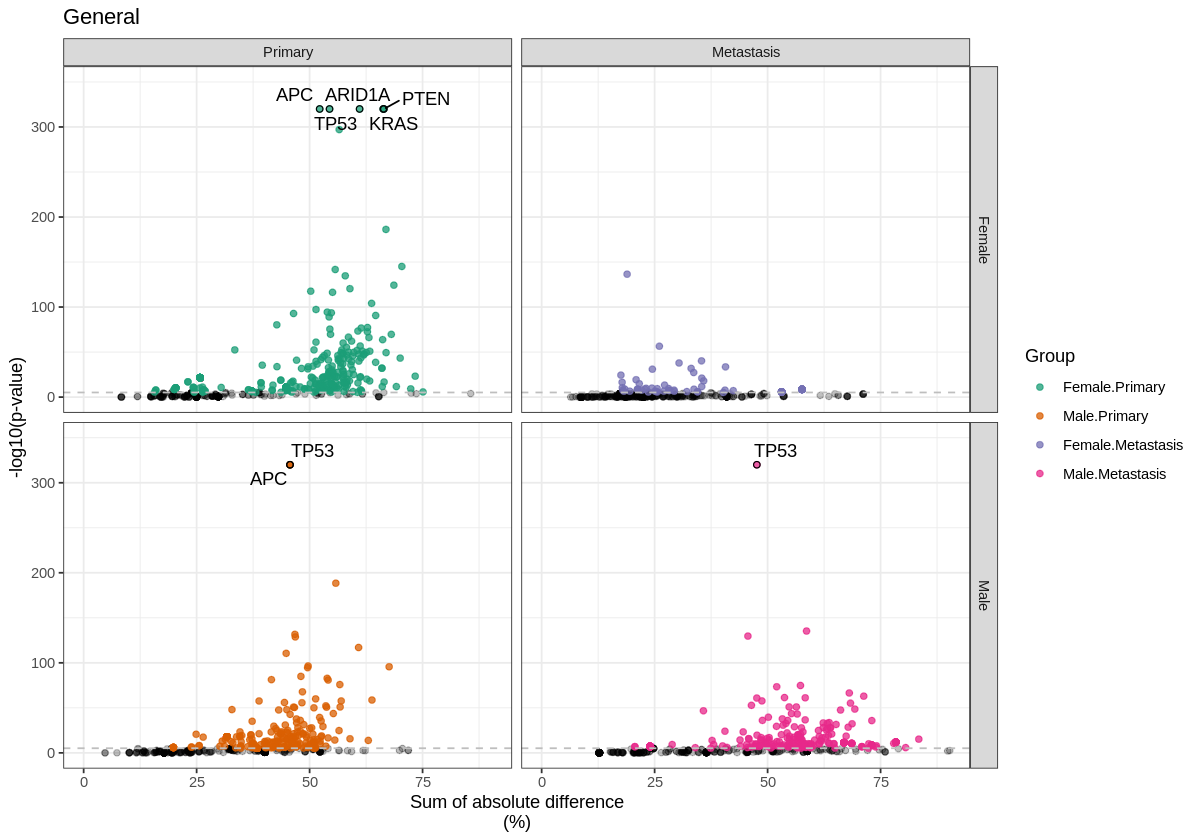

In [11]:
g_volcano_table$sex <- factor(g_volcano_table$sex, levels = c("Female", "Male"))
g_volcano_table$sample_type <- factor(g_volcano_table$sample_type, levels = c("Primary", "Metastasis"))

sig <- g_volcano_table %>% filter(significant == 'yes')
not_sig <- g_volcano_table %>% filter(significant == 'no')

interest <- g_volcano_table %>% filter(significant == 'yes' & -log10(p_value) >= 300)

ggplot(g_volcano_table, aes(x = sum_of_absolute_difference, y = -log10(p_value), label=as.character(Hugo_Symbol))) +
geom_point(data = not_sig, alpha=0.25) +
geom_point(data = sig, alpha=0.75, aes(group=interaction(sex, sample_type), colour=interaction(sex, sample_type))) +
geom_hline(yintercept=-log10(0.05/6764), linetype='dashed', colour='grey') +
geom_point(data = interest, shape=1, colour='black') +
geom_text_repel(data=interest, colour='black') +
scale_color_brewer(palette = "Dark2") +
labs(title = 'General') +
ylim(0, 350) +
xlim(0, NA) +
facet_grid(vars(sex), vars(sample_type)) +
xlab('Sum of absolute difference\n(%)') +
ylab('-log10(p-value)')  +
labs(colour='Group') +
theme_bw()

## General genes of interest

In [12]:
times_tested <- data.frame(matrix(ncol = 5, nrow = 0))
colnames(times_tested) <- c('cancer_type', 'n_tested', 'n_gtmin', 'n_significant', 'n_interest')

# Limiting search to the cancer we are currently looking at
test <- g_volcano_table

# Making p-value and n numeric
test$p_value = as.numeric(test$p_value)
test$n <- as.integer(test$n)

# Counting how often we have tested in this cancer-group
n_test <- nrow(test)

# How often we have genes with more than 100 observations
test2 <- test[which(test$n>100),]
n_gtmin <- nrow(test2)

# How often we find a gene to be significant
test3 <- test2[which(test2$p_value <= 0.05/n_test),]
n_significant <- nrow(test3)

# getting pvalue and sad quantiles
pval_quant <- as.double(quantile(test3$p_value, probs = 0.1))
sad_quant <- as.double(quantile(test3$sum_of_absolute_difference, probs = 0.9))

# how often do we find genes of interest
g_interest_table <- test3 %>% filter(p_value <= pval_quant | sum_of_absolute_difference >= sad_quant)
n_interest <- nrow(g_interest_table)

# Add it to our table, with genes of interest being counted later
times_tested[nrow(times_tested) + 1,] <- c('general', nrow(test), n_gtmin, n_significant, n_interest)

head(times_tested)

,cancer_type,n_tested,n_gtmin,n_significant,n_interest
,<chr>,<chr>,<chr>,<chr>,<chr>
1,general,6725,2401,1580,261


## Cancer specific genes of interest

Re-creating volcano table to find cancer-specific genes of interest

In [13]:
# Silencing the summarise warning from dyplr
options(dplyr.summarise.inform = FALSE)

# Creating an empty table for our results
volcano_table <- data.frame(matrix(ncol = 7, nrow = 0))
# Defining the column names for our volcano-table
colnames(volcano_table) <- c('cancer_type', 'Hugo_Symbol', 'sex', 'sample_type', 'sum_of_absolute_difference','p_value', 'n')

interest_table <- g_interest_table
interest_table <- cbind(cancer_type = 'General', interest_table) %>% select(-significant)

# We loop through each cancer-type using an index
for (idx in 1:length(cancer_list)){
    
    # By doing this we can define the cancer-name
    name <- cancer_list[idx]
    
    # define the file name
    file_name <- gsub(" ", "_", name)
    # define the file path to the expected frequencies for our chi2-gof test
    path_list <- c("../../derived_data/chi2_gof_test_expectations/", file_name, ".csv")
    file_path <- paste(path_list, collapse="")
    # And load our cancer-specific expectations
    expectations <- read.csv(file_path, header=TRUE, stringsAsFactors=FALSE)
    # We remove an unimportant indexing row
    expectations <- expectations %>% select(-X)
    # And make the age-interval column a factor with our defined age-level order
    expectations$age_interval <- factor(expectations$age_interval, levels=age_interval_levels)
    
    # We can also use the file-name to define our cancer-specific chi2-gof test result path
    path_list <- c("../../derived_data/chi2_gof_test_results/", file_name, ".csv")
    file_path <- paste(path_list, collapse="")
    # And load in the cancer-specific results
    chi_test <- read.csv(file_path, header=TRUE, stringsAsFactors=FALSE)
    # Again removing the unnecessary indexing column X
    chi_test <- chi_test %>% select(-X)

    # Selecting only pathogens found in in our cancer-type
    cancer_pathogen <- pathogen[which(pathogen$cancer_type == name),]
    
    # Then we create a new table which groups our pathogens by mutation, age, sex and sample-type
    # and counts how many are present in that group
    observed_mutations <- cancer_pathogen %>%
      group_by(Hugo_Symbol,age_interval,SEX,SAMPLE_TYPE) %>%
      summarise(n = n())
    
    # For this dataframe we also define our age-interval order
    observed_mutations$age_interval <- factor(observed_mutations$age_interval, levels=age_interval_levels)
    
    # And we make sure it is in the data-frame class
    observed_mutations <- as.data.frame(observed_mutations)
    
    # We start with the normal case where there are two sexes and sample types
    if (length(unique(expectations$SEX)) == 2){
        # Then we loop through each of our age-intervals
        for (age_lvl in age_interval_levels){
            # And each unique mutation found in our cancer
            for (mut in unique(observed_mutations$Hugo_Symbol)){
                
                # We create four temporary dataframe containing a subset of the observed mutation
                # The subset represents a specific mutation-age-sex-sampletype group
                # If that group has no observed mutations, the number of rows will be zero
                # and we need to add a count of 0 to our observations
                
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Primary'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = 'Male'
                    observed_mutations[nrow(observed_mutations), 4] = 'Primary'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = 'Male'
                    observed_mutations[nrow(observed_mutations), 4] = 'Metastasis'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Primary'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = 'Female'
                    observed_mutations[nrow(observed_mutations), 4] = 'Primary'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = 'Female'
                    observed_mutations[nrow(observed_mutations), 4] = 'Metastasis'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }        
            }
        }
        # Again, we loop through each mutation in our cancer specific expectations
        for (mut in unique(expectations$Hugo_Symbol)){
            # If the mutation is also observed in our observations for the group, we continue the loop
            if (mut %in% unique(observed_mutations$Hugo_Symbol)){
                
                # We define four expectations by matching mutation, sex and sample-type
                # Each expectation vector contains one value for each age-interval in the order of the age-intervals
                exp_mp <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Male' & expectations$SAMPLE_TYPE=='Primary'),6]
                exp_fp <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Female' & expectations$SAMPLE_TYPE=='Primary'),6]
                exp_mm <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Male' & expectations$SAMPLE_TYPE=='Metastasis'),6]
                exp_fm <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX=='Female' & expectations$SAMPLE_TYPE=='Metastasis'),6]
                
                # In a similar fashion we find four observations by matching mutation, sex and sample-type
                # Here we do not get a single vector, but a section of the observed-mutations dataframe
                # This is to be able to sort our observations by the age-interval order, whereafter we slice it into a vector with one observation for each age-interval
                # We also make the observations into percentages by dividing with the sum of the observations
                # We save the sum of the observations as a variable to add to our results, as it might be interesting
                obs_mp <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Primary'),]
                obs_mp <- obs_mp[order(obs_mp$age_interval), 5]
                n_mp <- sum(obs_mp)
                obs_mp <- obs_mp/n_mp
                obs_fp <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Primary'),]
                obs_fp <- obs_fp[order(obs_fp$age_interval), 5]
                n_fp <- sum(obs_fp)
                obs_fp <- obs_fp/n_fp
                obs_mm <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Male' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                obs_mm <- obs_mm[order(obs_mm$age_interval), 5]
                n_mm <- sum(obs_mm)
                obs_mm <- obs_mm/n_mm
                obs_fm <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX=='Female' & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                obs_fm <- obs_fm[order(obs_fm$age_interval), 5]
                n_fm <- sum(obs_fm)
                obs_fm <- obs_fm/n_fm
                
                # Matching mutation, sex and sample-type we can extract the p-value from our chi2-gof-test results
                p_val_mp <- chi_test[which(chi_test$Hugo_Symbol==mut & chi_test$sex=='Male' & chi_test$sample_type=='Primary'),6]
                p_val_fp <- chi_test[which(chi_test$Hugo_Symbol==mut & chi_test$sex=='Female' & chi_test$sample_type=='Primary'),6]
                p_val_mm <- chi_test[which(chi_test$Hugo_Symbol==mut & chi_test$sex=='Male' & chi_test$sample_type=='Metastasis'),6]
                p_val_fm <- chi_test[which(chi_test$Hugo_Symbol==mut & chi_test$sex=='Female' & chi_test$sample_type=='Metastasis'),6]
                
                # Then we calculate sum of the absolute differences between expected and observed
                # To make it more readable later we make it a percentage instead of a float by timing with 100
                diff_mp <- sum(abs(exp_mp-obs_mp)*100)
                diff_fp <- sum(abs(exp_fp-obs_fp)*100)
                diff_mm <- sum(abs(exp_mm-obs_mm)*100)
                diff_fm <- sum(abs(exp_fm-obs_fm)*100)
                
                # Then, if the p-value exists for a specific combination of cancer-mutation-sex-sampletype,
                # We add it to our volcano-table
                if (length(p_val_mp)==1){
                    volcano_table[nrow(volcano_table) + 1,] <- c(name, mut, 'Male', 'Primary', diff_mp, p_val_mp, n_mp)                    
                }
                
                if (length(p_val_fp)==1){
                    volcano_table[nrow(volcano_table) + 1,] <- c(name, mut, 'Female', 'Primary', diff_fp, p_val_fp, n_fp)
                }
                
                if (length(p_val_mm)==1){
                    volcano_table[nrow(volcano_table) + 1,] <- c(name, mut, 'Male', 'Metastasis', diff_mm, p_val_mm, n_mm)
                }
                
                if (length(p_val_fm)==1){
                    volcano_table[nrow(volcano_table) + 1,] <- c(name, mut, 'Female', 'Metastasis', diff_fm, p_val_fm, n_fm)
                }
            }
        }
    # If there is only one sex we do the same, but for only two groups
    } else if (length(unique(expectations$SEX)) == 1) {
        # We define the sex found in our expectations
        the_sex <- unique(expectations$SEX)
        
        for (age_lvl in age_interval_levels){
            for (mut in unique(observed_mutations$Hugo_Symbol)){
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX==the_sex & observed_mutations$SAMPLE_TYPE=='Primary'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = the_sex
                    observed_mutations[nrow(observed_mutations), 4] = 'Primary'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }
                tmp <- observed_mutations[which(observed_mutations$age_interval==age_lvl & observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX==the_sex & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                if (nrow(tmp)==0){
                    observed_mutations[nrow(observed_mutations)+1, 1] = mut
                    observed_mutations[nrow(observed_mutations), 2] = age_lvl
                    observed_mutations[nrow(observed_mutations), 3] = the_sex
                    observed_mutations[nrow(observed_mutations), 4] = 'Metastasis'
                    observed_mutations[nrow(observed_mutations), 5] = 0
                }        
            }
        }
        
        for (mut in unique(expectations$Hugo_Symbol)){
            if (mut %in% unique(observed_mutations$Hugo_Symbol)){
                
                exp_xp <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX==the_sex & expectations$SAMPLE_TYPE=='Primary'),6]
                exp_xm <- expectations[which(expectations$Hugo_Symbol==mut & expectations$SEX==the_sex & expectations$SAMPLE_TYPE=='Metastasis'),6]
                
                obs_xp <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX==the_sex & observed_mutations$SAMPLE_TYPE=='Primary'),]
                obs_xp <- obs_xp[order(obs_xp$age_interval), 5]
                n_xp <- sum(obs_xp)
                obs_xp <- obs_xp/n_xp
                obs_xm <- observed_mutations[which(observed_mutations$Hugo_Symbol==mut & observed_mutations$SEX==the_sex & observed_mutations$SAMPLE_TYPE=='Metastasis'),]
                obs_xm <- obs_xm[order(obs_xm$age_interval), 5]
                n_xm <- sum(obs_xm)
                obs_xm <- obs_xm/n_xm
                
                diff_xp <- sum(abs(exp_xp-obs_xp)*100)
                diff_xm <- sum(abs(exp_xm-obs_xm)*100)
                
                p_val_xp <- chi_test[which(chi_test$Hugo_Symbol==mut & chi_test$sex==the_sex & chi_test$sample_type=='Primary'),6]
                p_val_xm <- chi_test[which(chi_test$Hugo_Symbol==mut & chi_test$sex==the_sex & chi_test$sample_type=='Metastasis'),6]
                
                
                if (length(p_val_xp)==1){
                    volcano_table[nrow(volcano_table) + 1,] <- c(name, mut, the_sex, 'Primary', diff_xp, p_val_xp, n_xp)
                }
                
                if (length(p_val_xm)==1){
                    volcano_table[nrow(volcano_table) + 1,] <- c(name, mut, the_sex, 'Metastasis', diff_xm, p_val_xm, n_xm)
                }
            }
        } 
    }
    
    # Limiting search to the cancer we are currently looking at
    test <- volcano_table[which(volcano_table$cancer_type==name),]

    # Making p-value and n numeric
    test$p_value = as.numeric(test$p_value)
    test$sum_of_absolute_difference = as.numeric(test$sum_of_absolute_difference)
    test$n <- as.integer(test$n)
    
    # Counting how often we have tested in this cancer-group
    n_test <- nrow(test)
    
    # How often we have genes with more than 10 observations
    test2 <- test[which(test$n>10),]
    n_gtmin <- nrow(test2)
    
    # How often we find a gene to be significant
    test3 <- test2[which(test2$p_value <= 0.05/n_test),]
    n_significant <- nrow(test3)
    
    # getting pvalue and sad quantiles
    pval_quant <- as.double(quantile(test3$p_value, probs = 0.1))
    sad_quant <- as.double(quantile(test3$sum_of_absolute_difference, probs = 0.9))

    # how often do we find genes of interest
    cs_interest_table <- test3 %>% filter(p_value <= pval_quant | sum_of_absolute_difference >= sad_quant)
    n_interest <- nrow(cs_interest_table)

    # Add it to our table, with genes of interest being counted later
    times_tested[nrow(times_tested) + 1,] <- c(name, nrow(test), n_gtmin, n_significant, n_interest)
    
    interest_table <- rbind(interest_table, cs_interest_table)

}

# We make the difference and p-value numeric in our table
volcano_table$sum_of_absolute_difference = as.numeric(volcano_table$sum_of_absolute_difference)
volcano_table$p_value = as.numeric(volcano_table$p_value)
volcano_table$n <- as.integer(volcano_table$n)

print('done')

[1] "done"


In [14]:
dim(volcano_table)
head(volcano_table)

[1] 7994    7

,cancer_type,Hugo_Symbol,sex,sample_type,sum_of_absolute_difference,p_value,n
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,Bladder Cancer,MUTYH,Male,Primary,89.95689,9.503583e-02,7
2,Bladder Cancer,MUTYH,Female,Primary,87.28614,2.313487e-01,4
3,Bladder Cancer,MUTYH,Male,Metastasis,125.02229,4.101850e-01,2
4,Bladder Cancer,DDR2,Male,Primary,59.94594,2.821562e-03,29
5,Bladder Cancer,DDR2,Female,Primary,85.48693,3.052814e-01,5
6,Bladder Cancer,DDR2,Male,Metastasis,108.44590,1.790830e-09,14


In [15]:
dim(times_tested)
head(times_tested)

[1] 17  5

,cancer_type,n_tested,n_gtmin,n_significant,n_interest
,<chr>,<chr>,<chr>,<chr>,<chr>
1,general,6725,2401,1580,261
2,Bladder Cancer,801,319,159,40
3,Breast Cancer,719,393,94,20
4,Colorectal Cancer,124,66,14,4
5,Endometrial Cancer,690,478,176,29
6,Esophagogastric Cancer,788,237,25,6


In [16]:
times_tested

,cancer_type,n_tested,n_gtmin,n_significant,n_interest
,<chr>,<chr>,<chr>,<chr>,<chr>
1,general,6725,2401,1580,261
2,Bladder Cancer,801,319,159,40
3,Breast Cancer,719,393,94,20
4,Colorectal Cancer,124,66,14,4
5,Endometrial Cancer,690,478,176,29
6,Esophagogastric Cancer,788,237,25,6
7,Glioma,80,13,0,0
8,Head and Neck Cancer,858,82,40,8
9,Hepatobiliary Cancer,48,0,0,0


In [17]:
write.csv(times_tested, "../../derived_data/chi2_gof_testing_overview", row.names=TRUE)

In [18]:
dim(interest_table)
head(interest_table)

[1] 442   7

,cancer_type,Hugo_Symbol,sex,sample_type,sum_of_absolute_difference,p_value,n
,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<int>
1,General,CDKN2A,Male,Primary,56.68998,1.432424e-76,907
2,General,CDKN2A,Female,Primary,63.13009,7.299446e-67,698
3,General,CDKN2A,Male,Metastasis,56.36045,1.030006e-51,660
4,General,TP53,Male,Primary,45.67578,9.999889e-321,12669
5,General,TP53,Female,Primary,54.41339,9.999889e-321,14193
6,General,TP53,Male,Metastasis,47.61708,9.999889e-321,7783


In [19]:
write.csv(interest_table, "../../derived_data/chi2_gof_results_of_interest", row.names=TRUE)

In [20]:
# Replacing p-values of zero with the highest value they can get before becoming zero

volcano_table <- volcano_table %>% mutate(p_value = replace(p_value, p_value == 0, 1e-320))

## Table of testing counts

In [21]:
test <- as.data.frame(table(interest_table$Hugo_Symbol))
print('how many gens found to be interesting in total')
nrow(test)
tmp <- test[which(test$Freq==1),]
unique_interest <- tmp[[1]]

unique_interest_table <- interest_table[which(interest_table$Hugo_Symbol %in% unique_interest), ]
print('how many genes found to be interesting only once')
nrow(unique_interest_table)

tmp2 <- test[which(test$Freq!=1),]
tmp2 <- tmp2[order(-tmp2$Freq), ]
print('how many genes found to be interesting more than once')
nrow(tmp2)

print('20 most often found to be interesting genes')
tmp2[1:15,]

[1] "how many gens found to be interesting in total"


[1] 191

[1] "how many genes found to be interesting only once"


[1] 67

[1] "how many genes found to be interesting more than once"


[1] 124

[1] "20 most often found to be interesting genes"


,Var1,Freq
,<fct>,<int>
181,TP53,22
22,BRAF,11
6,ARID1A,7
122,NF1,7
150,PTEN,7
4,APC,6
102,KMT2D,6
138,PIK3CA,6
10,ASXL1,5


In [22]:
tmp <- interest_table[which(interest_table$Hugo_Symbol=='TP53'),]
table(tmp$cancer_type)

tmp <- interest_table[which(interest_table$Hugo_Symbol=='TP53' &
                            interest_table$cancer_type != 'Endometrial Cancer' &
                            interest_table$cancer_type != 'Esophagogastric Cancer' &
                            interest_table$cancer_type != 'Ovarian Cancer' &
                            interest_table$cancer_type != 'Prostate Cancer'),]

tmp


         Bladder Cancer           Breast Cancer      Endometrial Cancer 
                      2                       2                       2 
 Esophagogastric Cancer                 General    Head and Neck Cancer 
                      3                       4                       2 
Mature B-Cell Neoplasms                Melanoma          Ovarian Cancer 
                      1                       1                       1 
        Prostate Cancer     Soft Tissue Sarcoma          Thyroid Cancer 
                      2                       1                       1 

,cancer_type,Hugo_Symbol,sex,sample_type,sum_of_absolute_difference,p_value,n
,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<int>
4,General,TP53,Male,Primary,45.67578,9.999889e-321,12669
5,General,TP53,Female,Primary,54.41339,9.999889e-321,14193
6,General,TP53,Male,Metastasis,47.61708,9.999889e-321,7783
7,General,TP53,Female,Metastasis,18.91071,3.272749e-137,10682
286,Bladder Cancer,TP53,Male,Primary,34.72462,8.185682e-41,1061
287,Bladder Cancer,TP53,Male,Metastasis,60.18137,7.526586e-89,391
313,Breast Cancer,TP53,Female,Primary,74.60537,1.705699e-314,1835
314,Breast Cancer,TP53,Female,Metastasis,46.46256,3.433178e-131,2070
361,Head and Neck Cancer,TP53,Male,Primary,99.36439,3.119620e-88,304


## Cancer-specific plots

Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


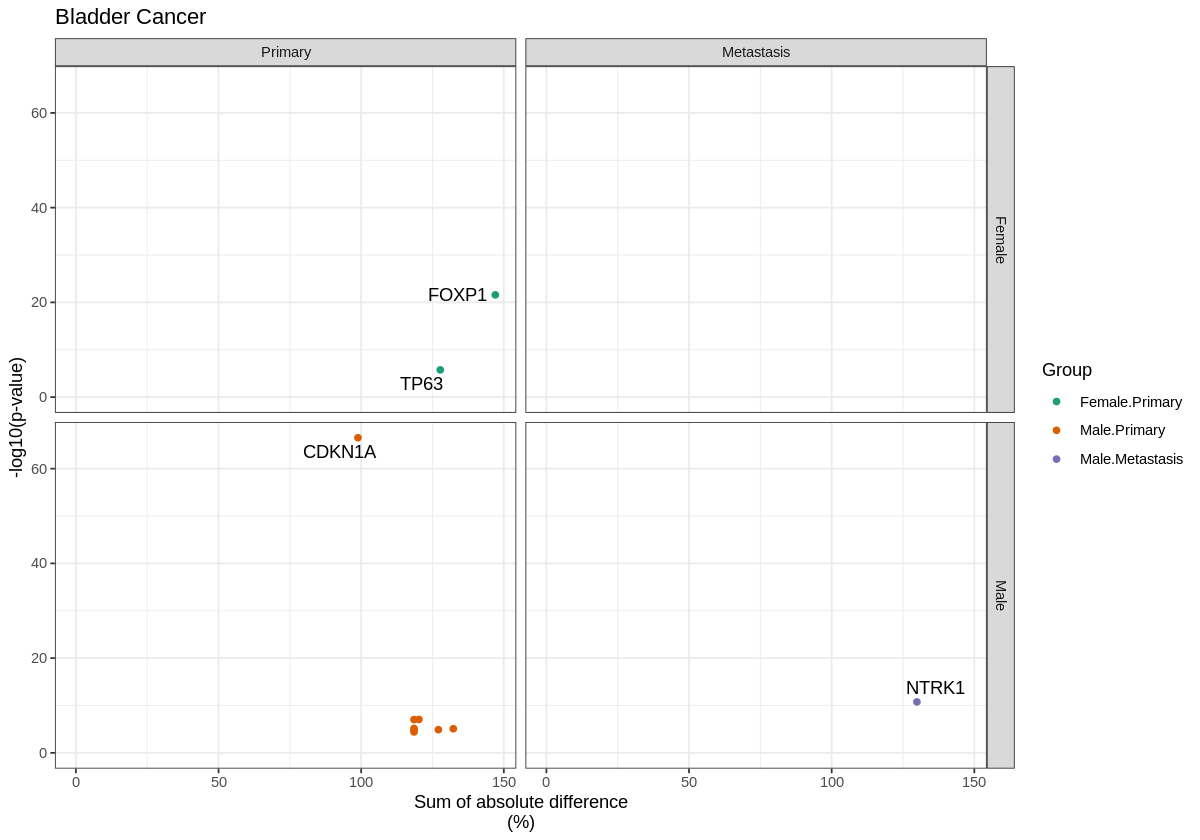

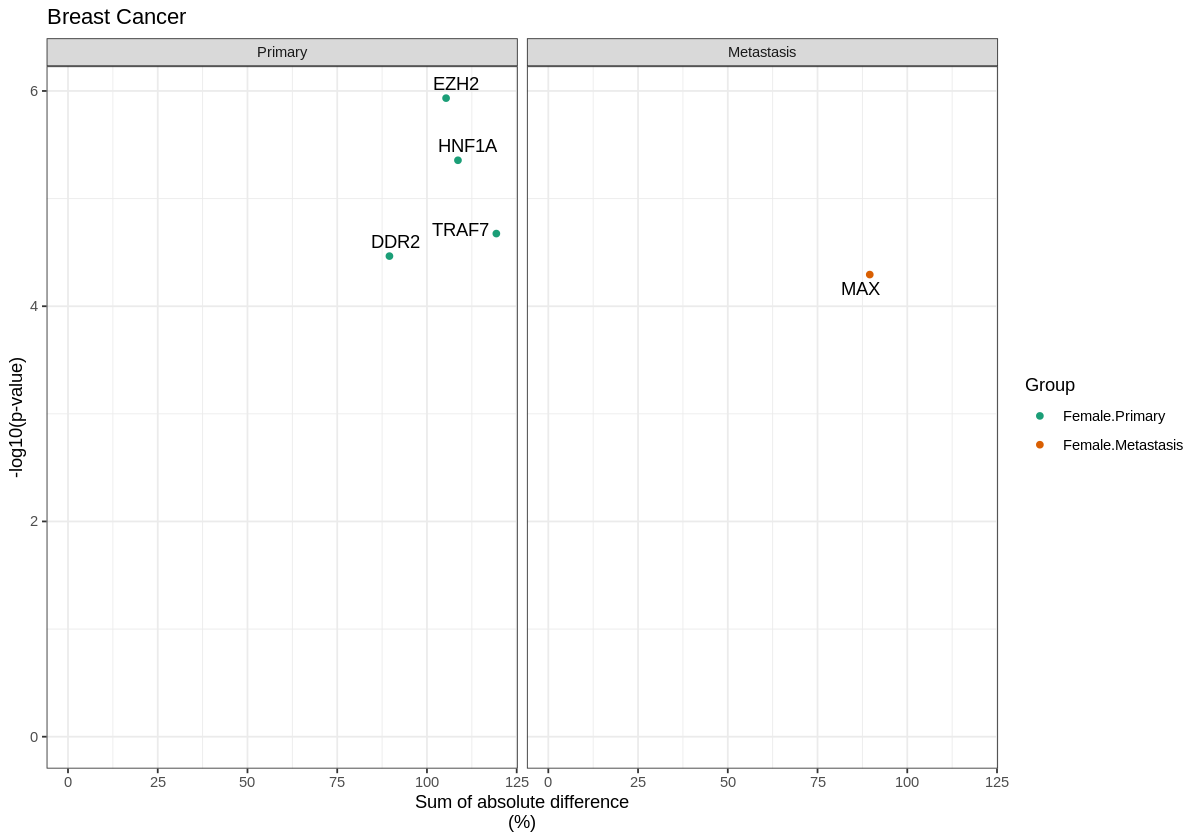

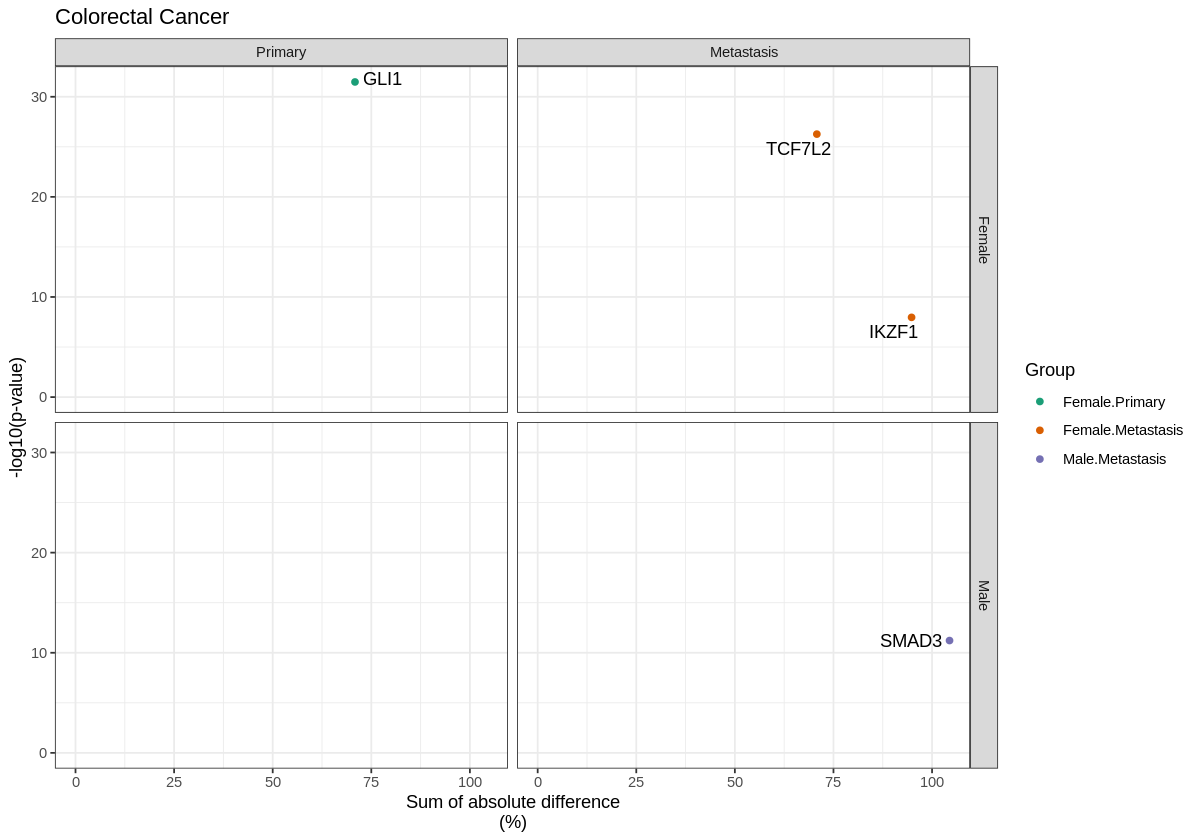

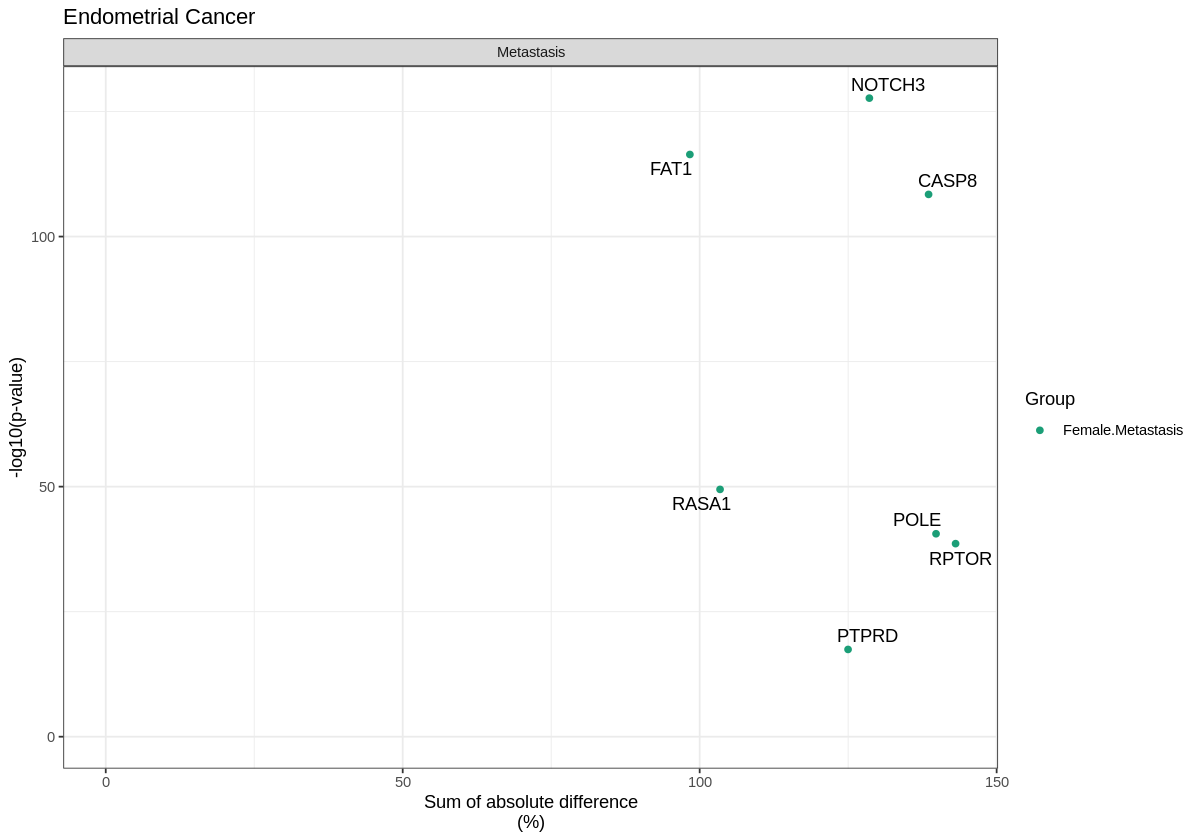

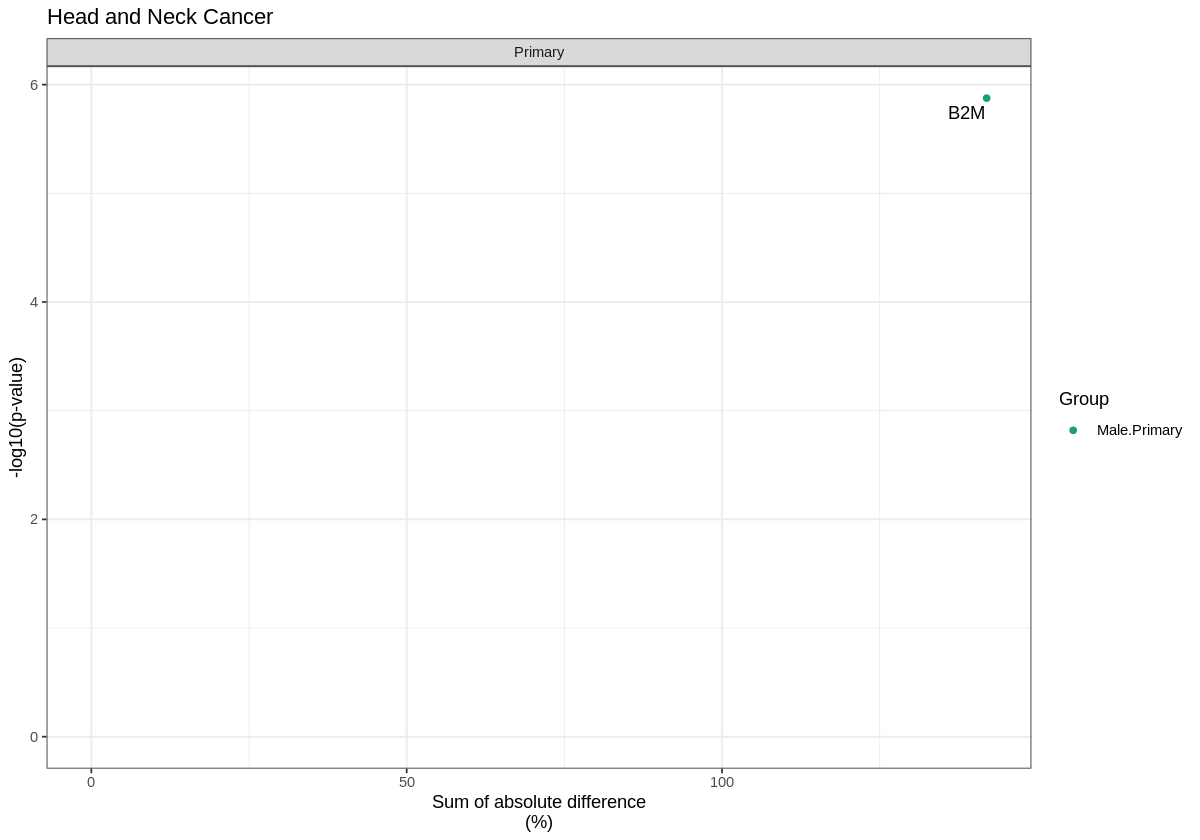

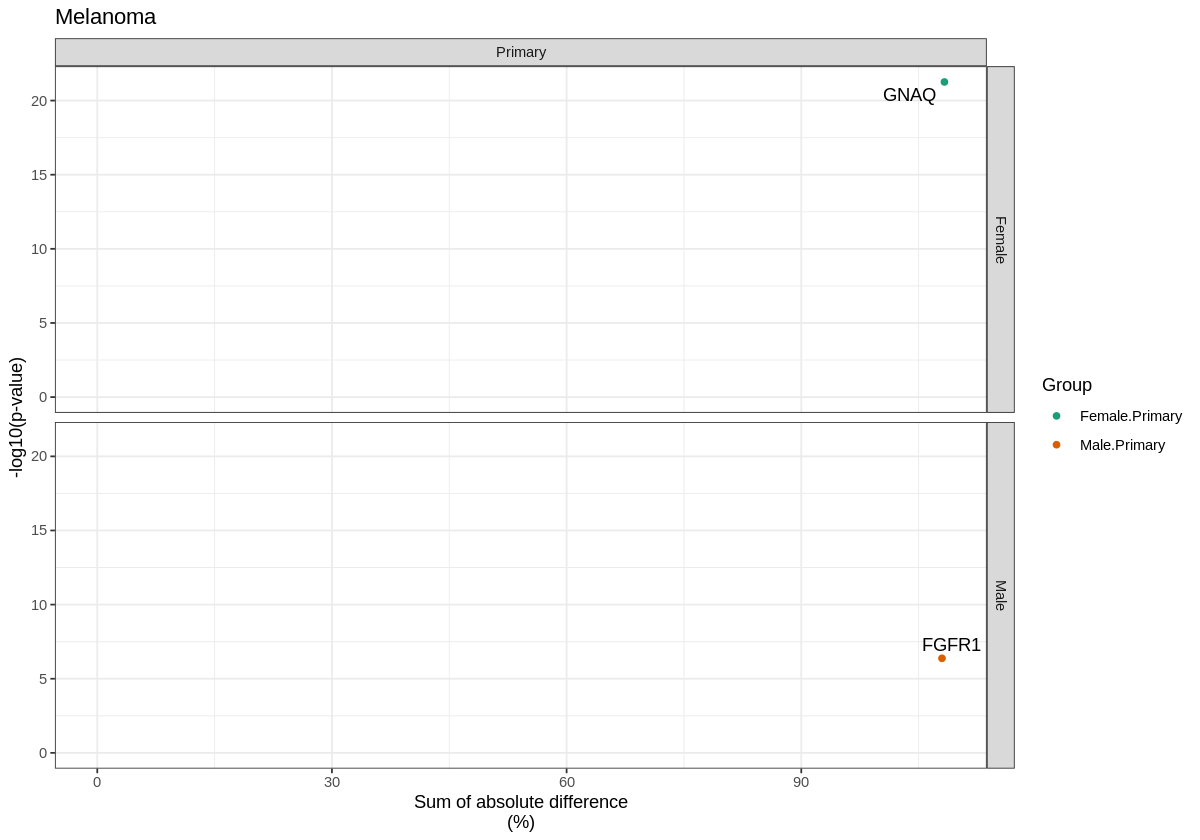

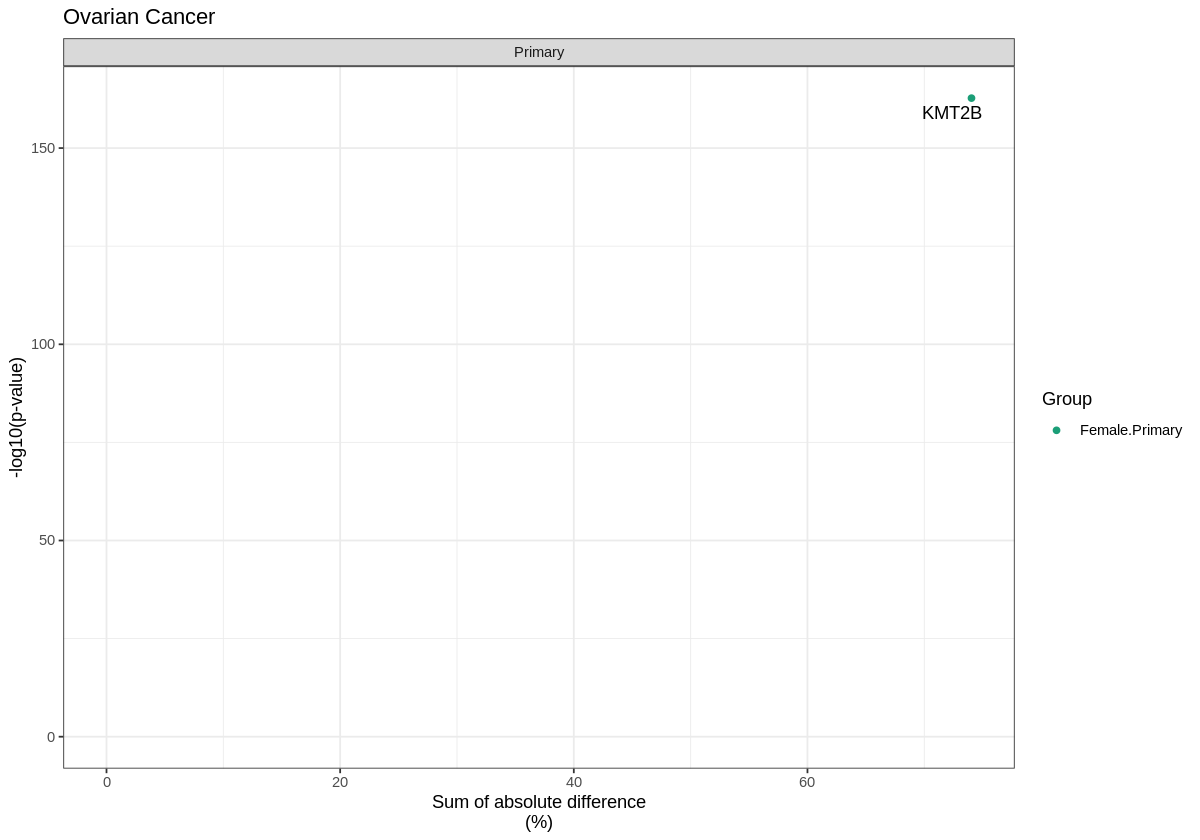

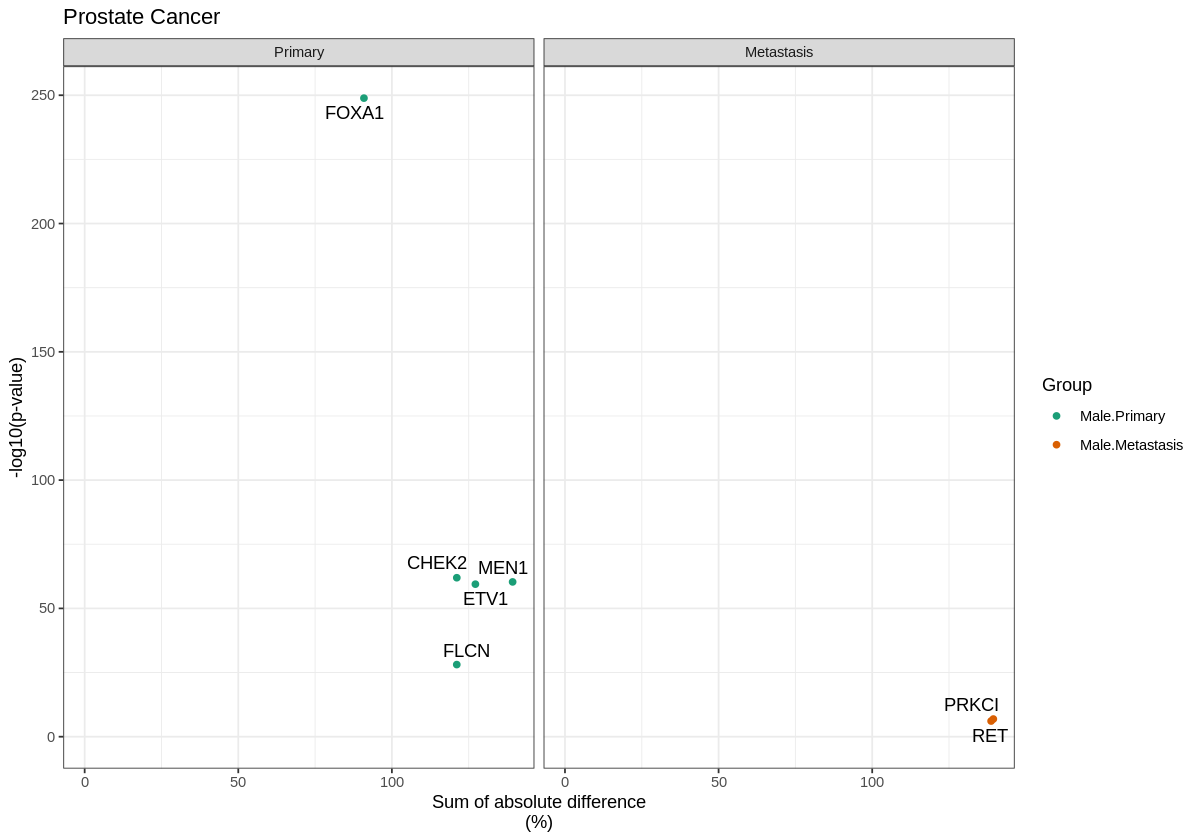

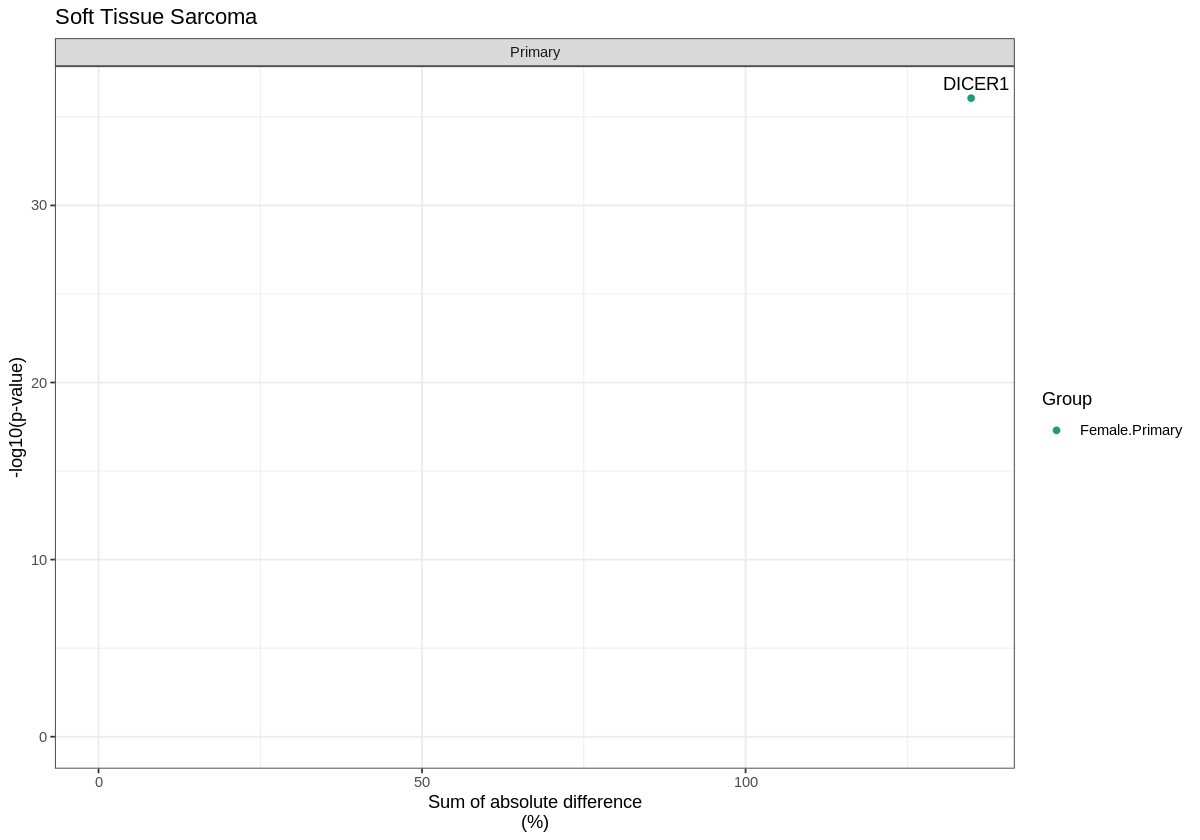

In [23]:
# Trying to make a plot of unique genes of interest

for (idx in 1:length(cancer_list)){
    
    name <- cancer_list[idx]
    file_name <- gsub(" ", "_", name)
    
    dat <- volcano_table[which(volcano_table$cancer_type==name),]
    
    test <- unique_interest_table[which(unique_interest_table$cancer_type == name), ]
    
    if (nrow(test) != 0){ #these cancer has no entires in volcano table
        n_tests <- as.integer(times_tested[which(times_tested$cancer_type==name), 2])

        dat <- dat %>% mutate(significant = case_when(p_value >= 0.05/n_tests ~ 'no',
                                 TRUE ~ 'yes'))

        sig <- dat %>% filter(significant == 'yes')
        
        not_sig <- dat %>% filter(significant == 'no')

        interest <- dat %>% filter(significant == 'yes' & -log10(p_value) >= 150)

        if (length(unique(test$sex)) == 1){
            q <- ggplot(test, aes(x = sum_of_absolute_difference, y = -log10(p_value), label=as.character(Hugo_Symbol))) +
            geom_point(aes(group=interaction(sex, sample_type), colour=interaction(sex, sample_type))) +
            geom_text_repel(colour='black') +
            scale_color_brewer(palette = "Dark2") +
            labs(title = name) +
            ylim(0, NA) +
            xlim(0, NA) +
            facet_wrap(~sample_type) +
            xlab('Sum of absolute difference\n(%)') +
            ylab('-log10(p-value)')  +
            labs(colour='Group') +
            theme_bw()     
        }else{
            q <- ggplot(test, aes(x = sum_of_absolute_difference, y = -log10(p_value), label=as.character(Hugo_Symbol))) +
            geom_point(aes(group=interaction(sex, sample_type), colour=interaction(sex, sample_type))) +
            geom_text_repel(colour='black') +
            scale_color_brewer(palette = "Dark2") +
            labs(title = name) +
            ylim(0, NA) +
            xlim(0, NA) +
            facet_grid(vars(sex), vars(sample_type)) +
            xlab('Sum of absolute difference\n(%)') +
            ylab('-log10(p-value)')  +
            labs(colour='Group') +
            theme_bw()
        }
            print(q)
    }
}

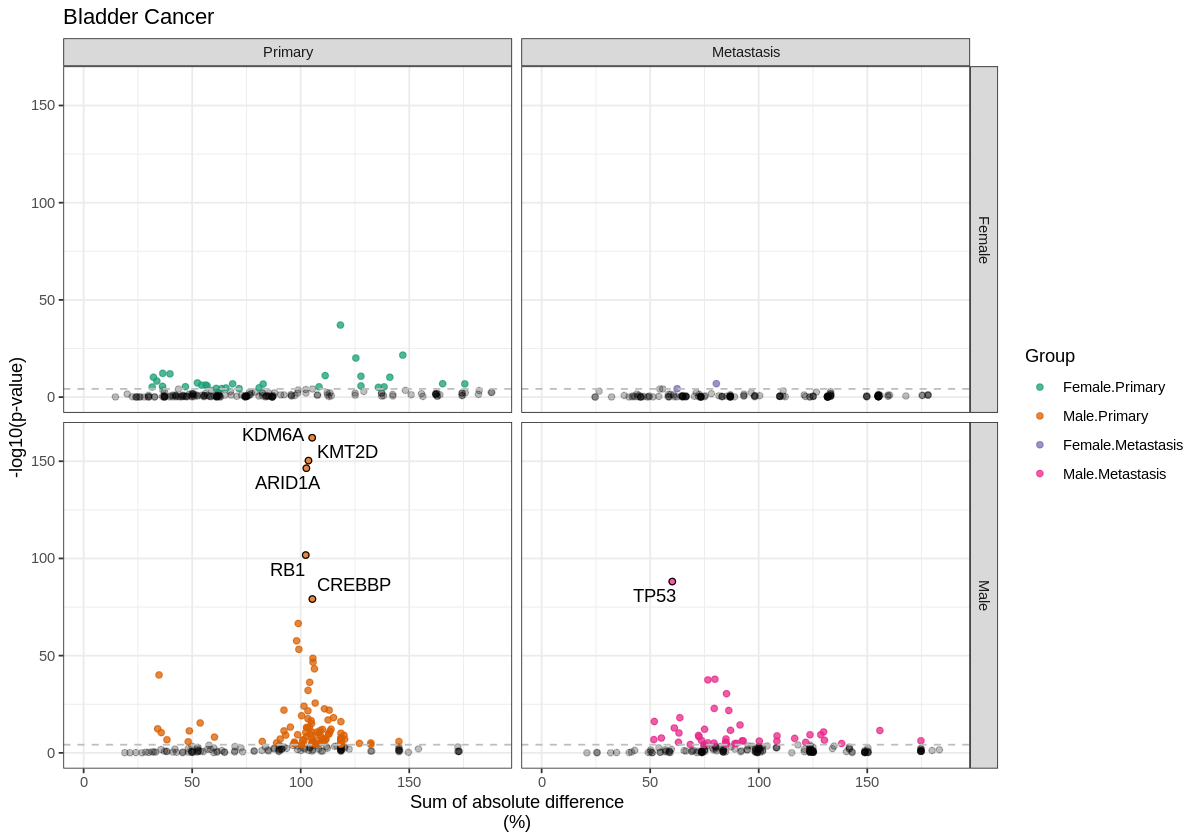

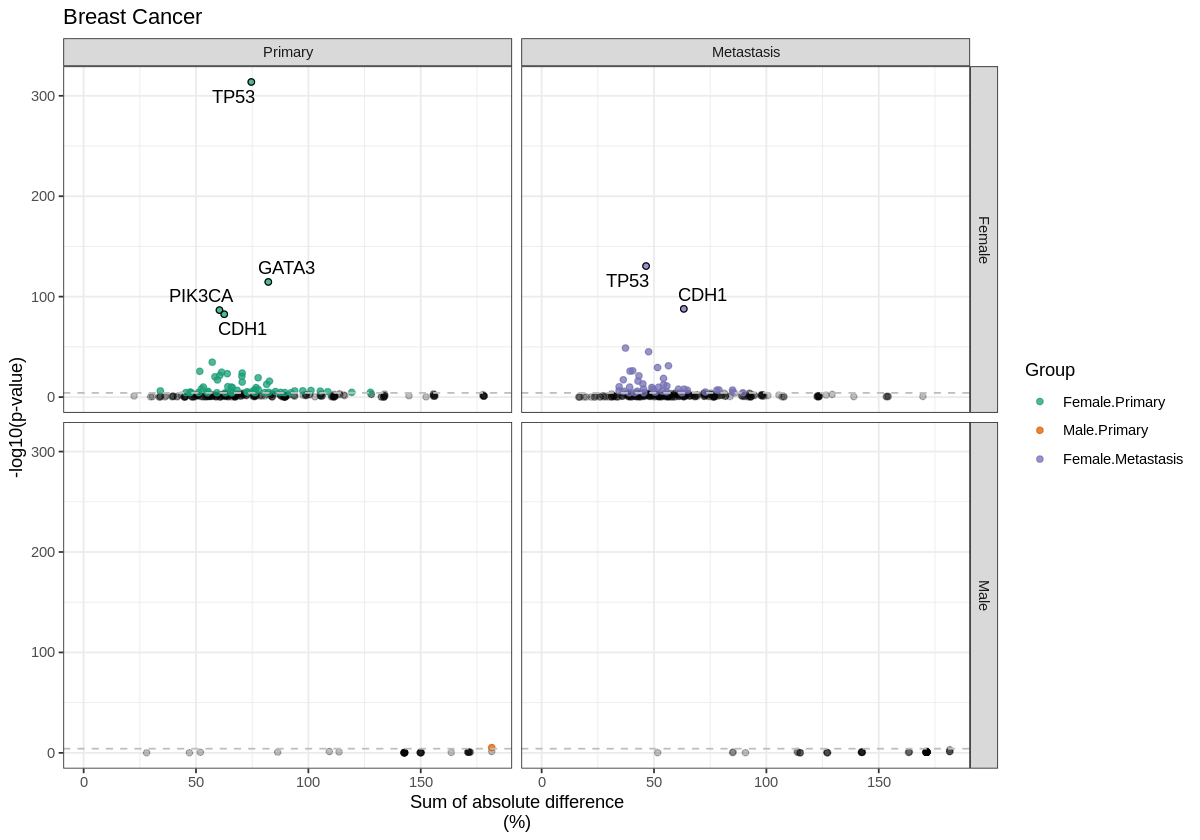

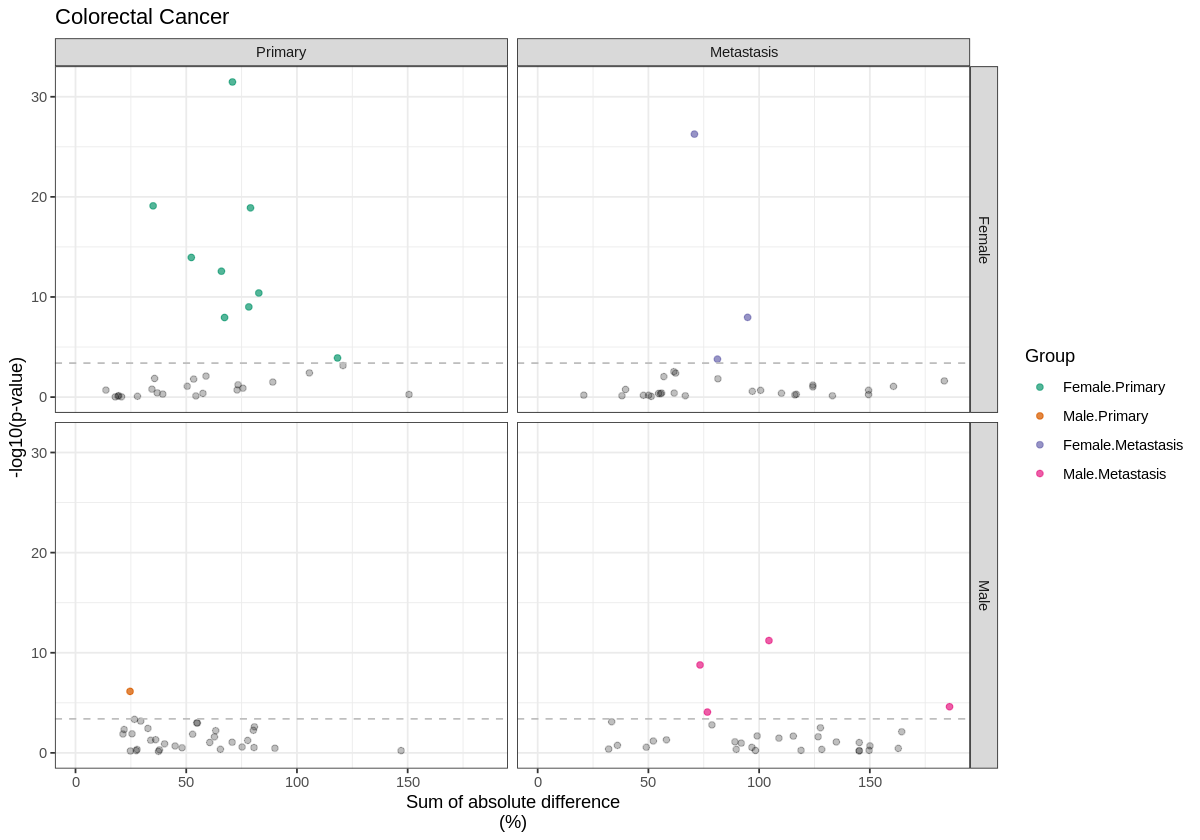

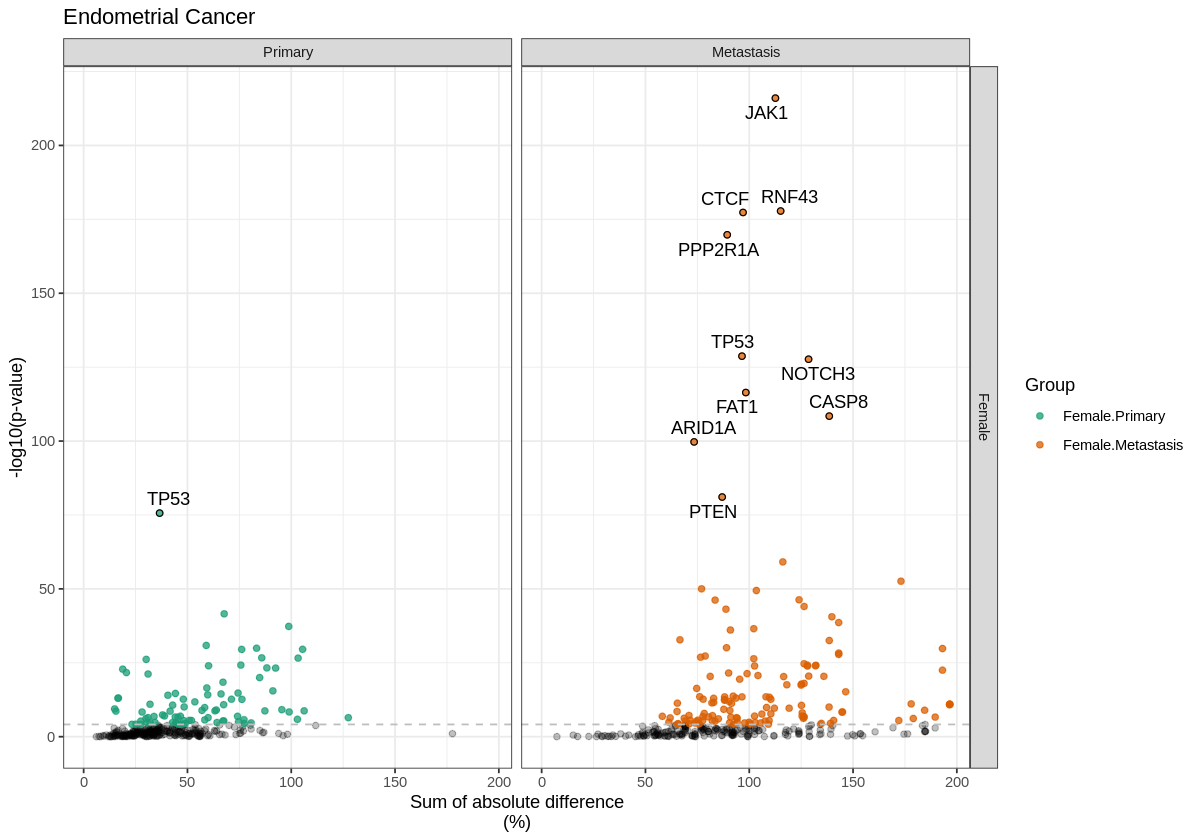

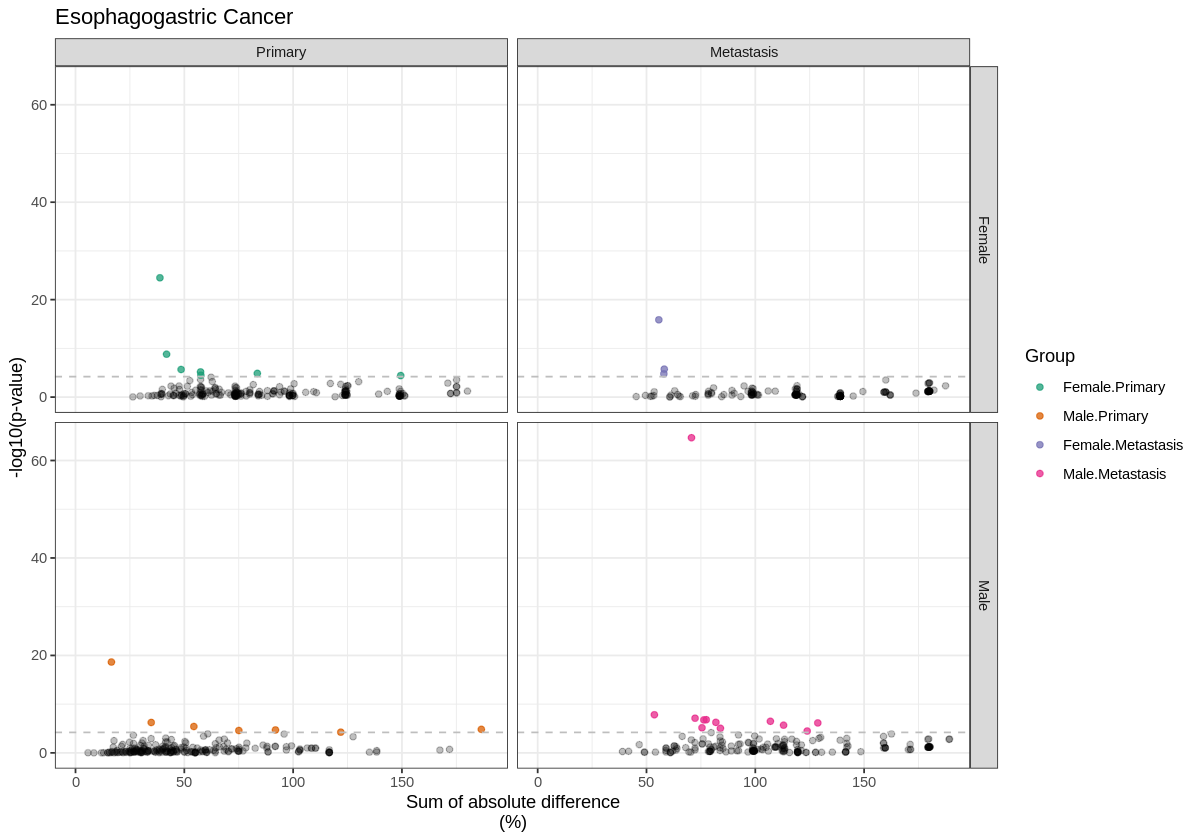

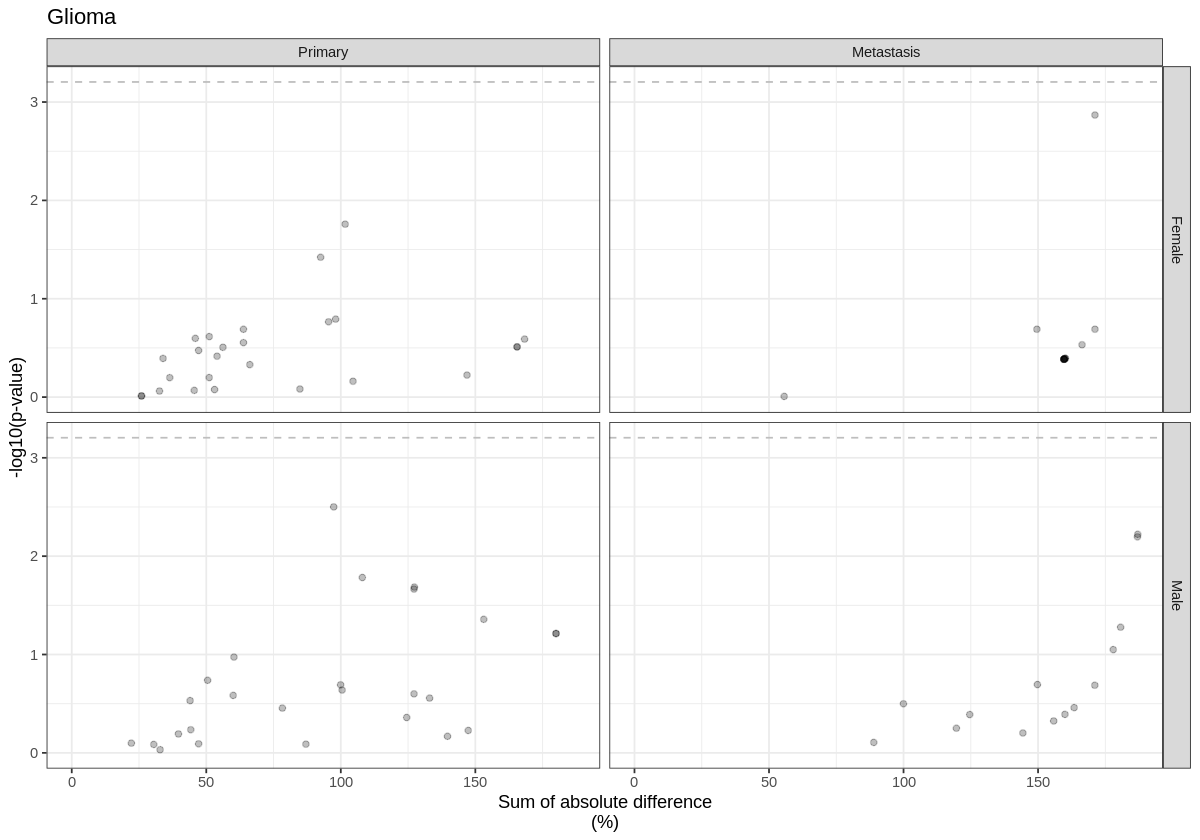

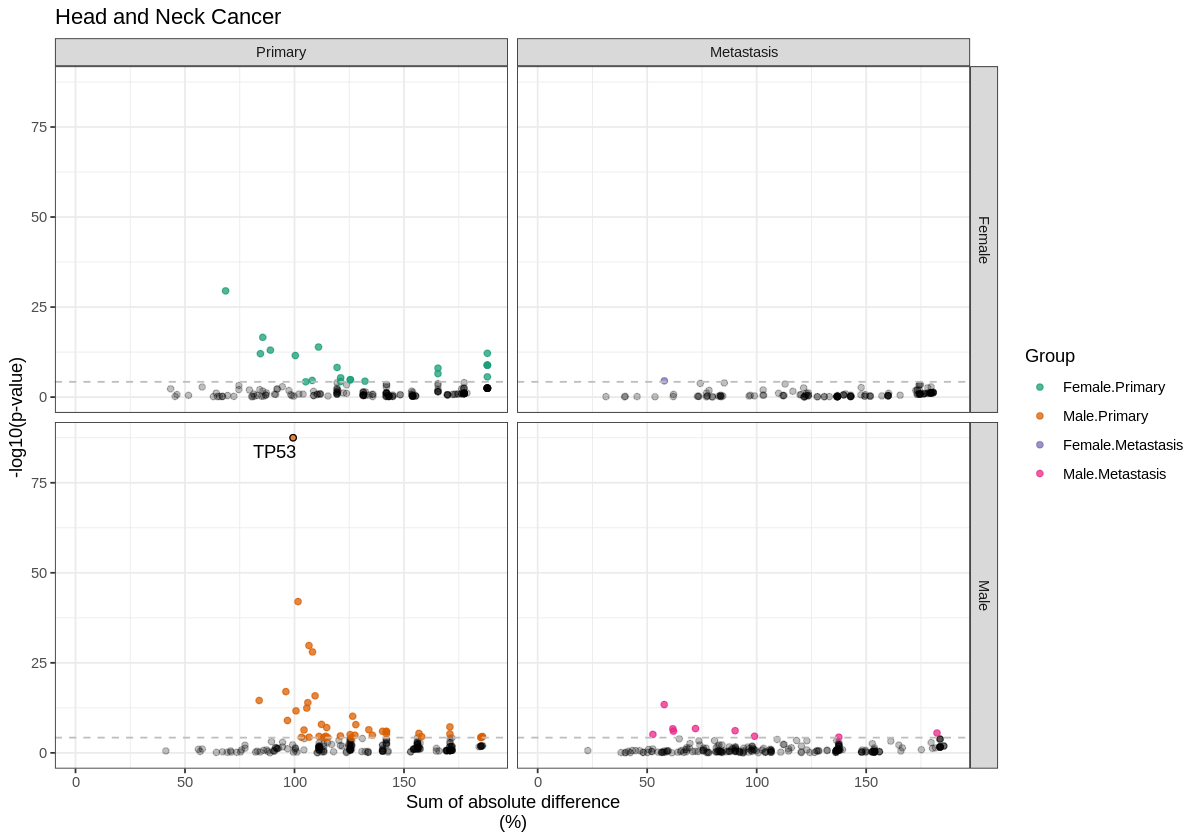

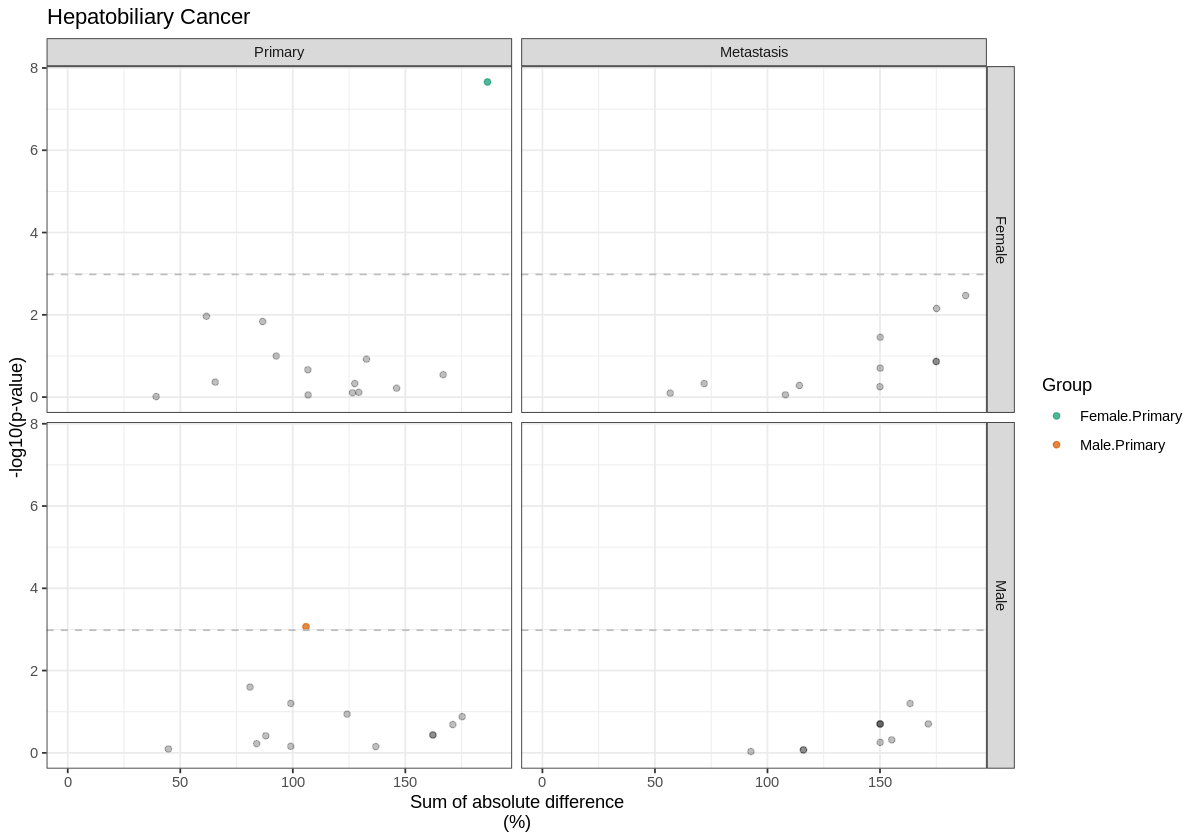

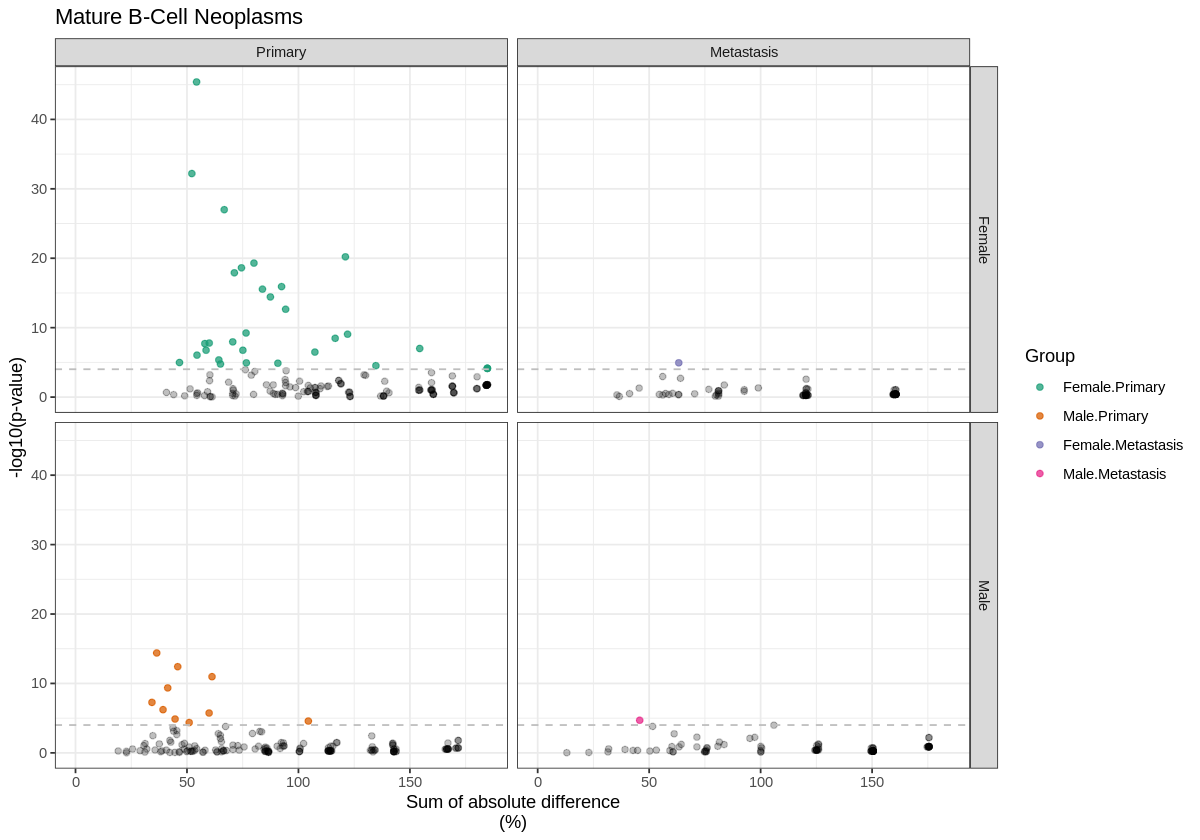

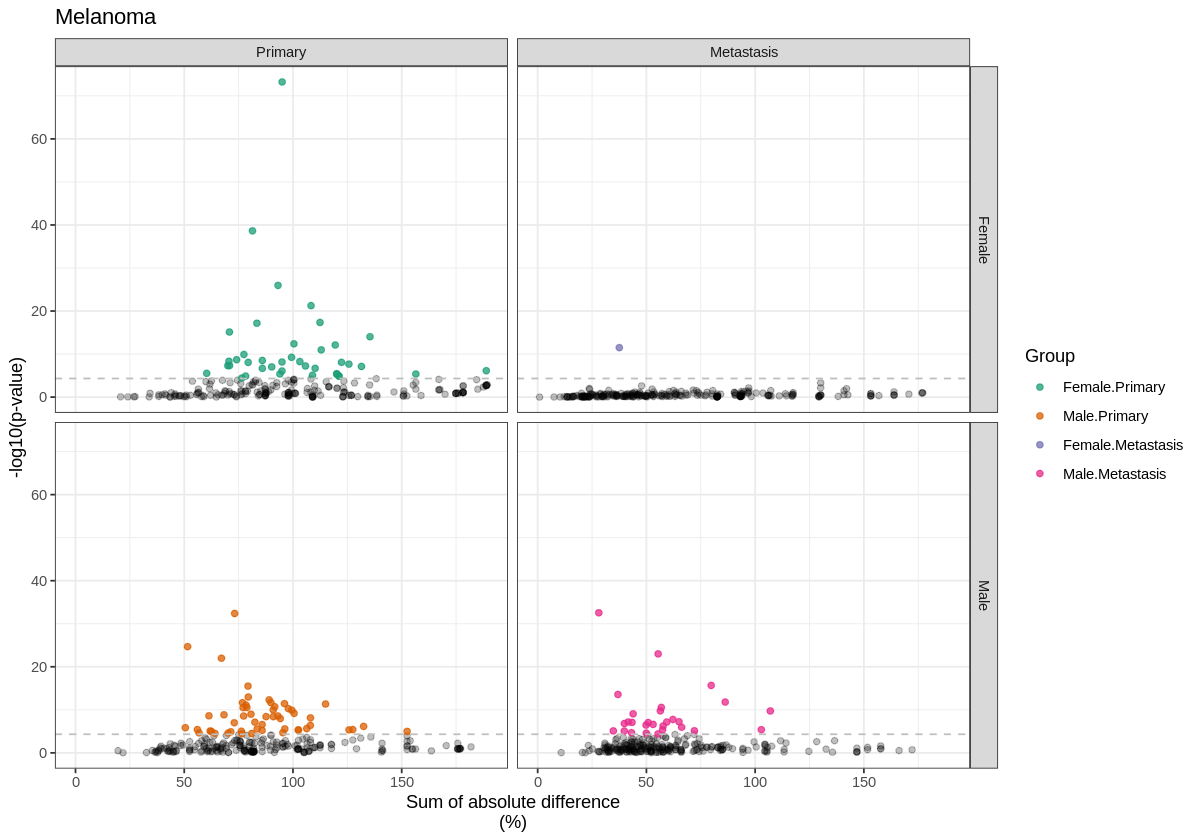

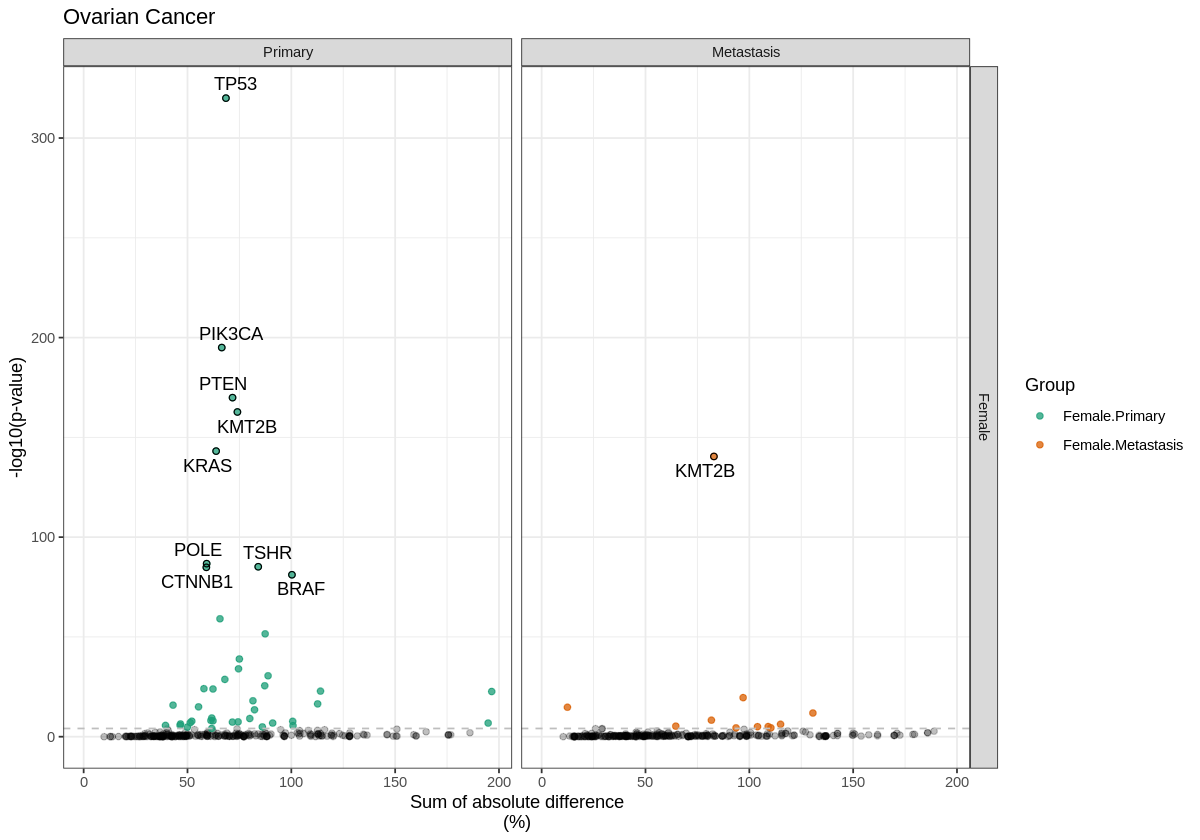

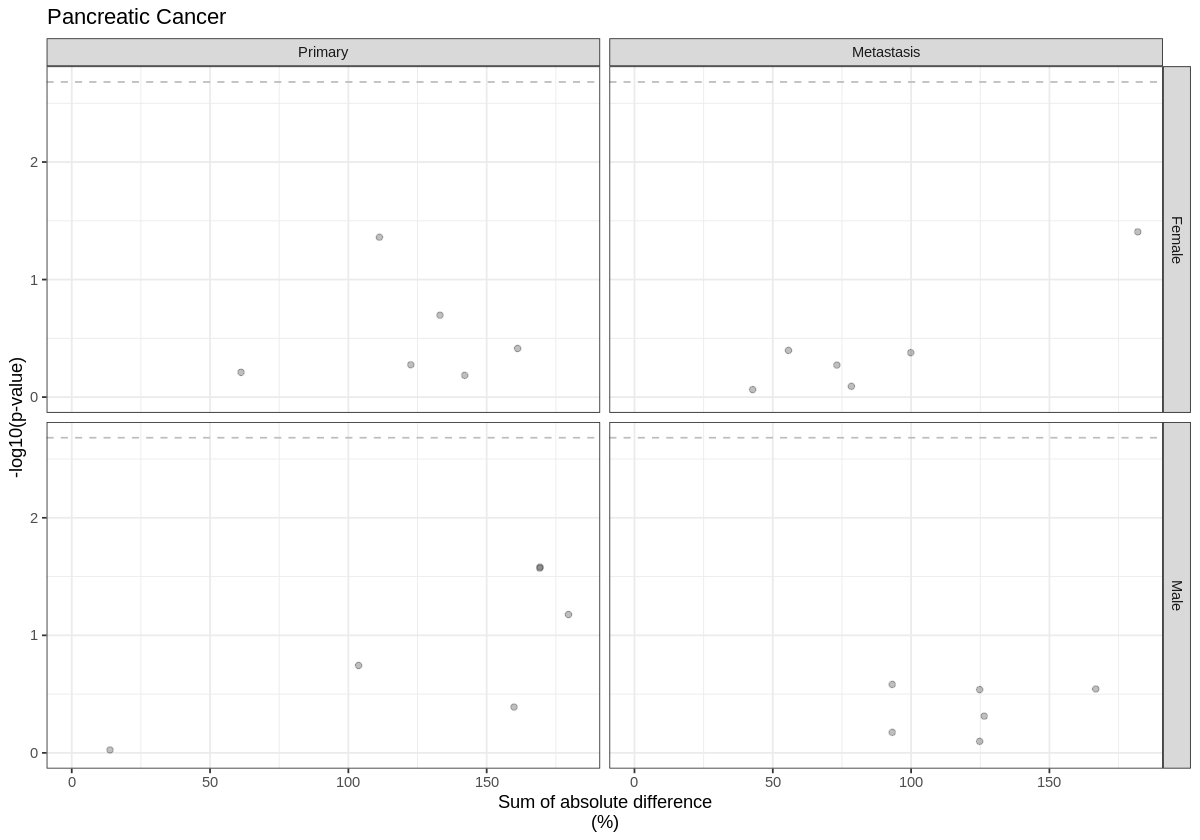

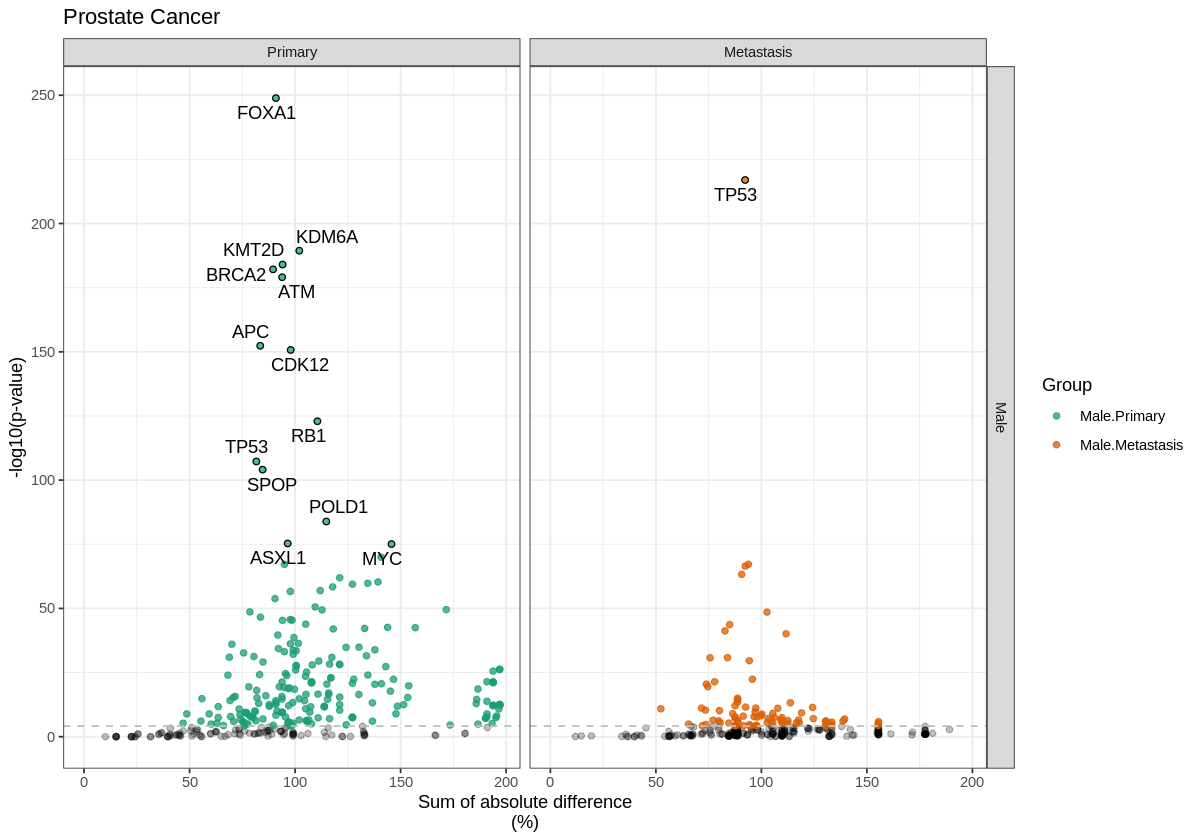

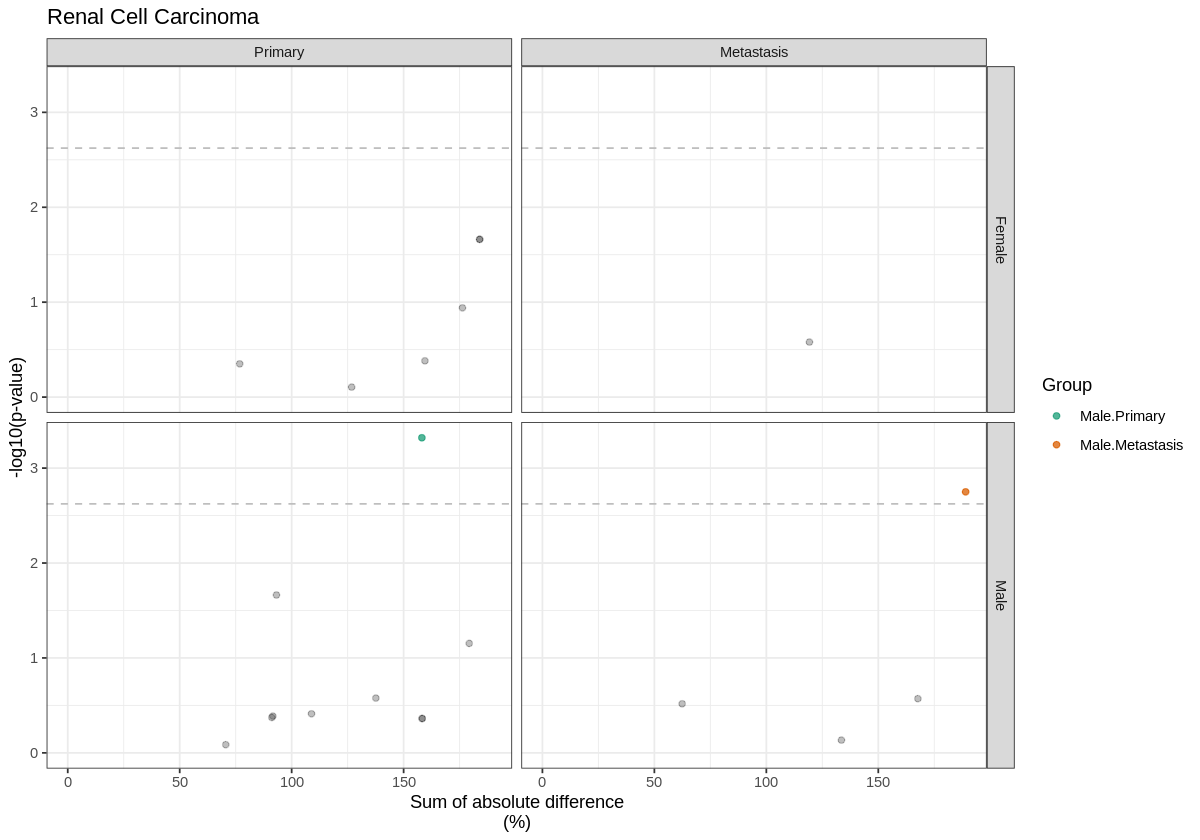

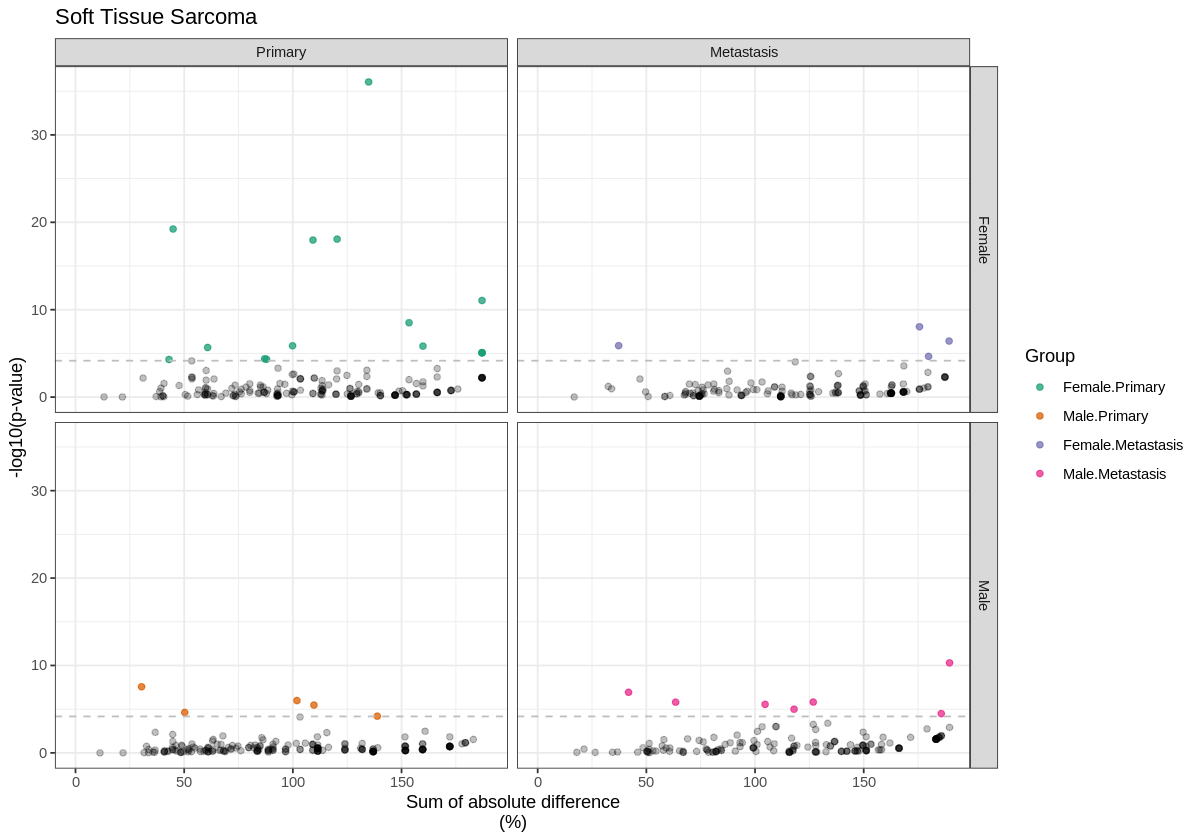

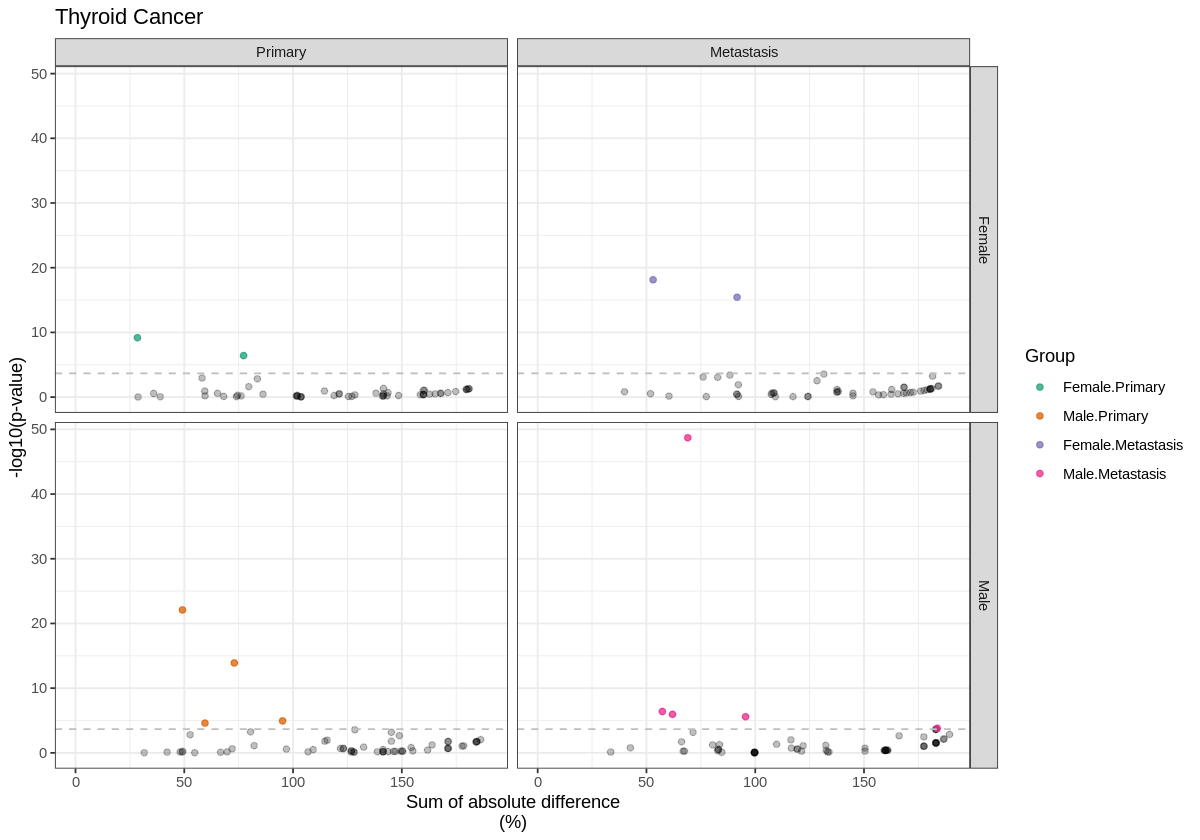

In [31]:
# Trying to make a plot of unique genes of interest

for (idx in 1:length(cancer_list)){
    
    name <- cancer_list[idx]
    file_name <- gsub(" ", "_", name)
    
    dat <- volcano_table[which(volcano_table$cancer_type==name),]
    
    dat$sex <- factor(dat$sex, levels = c("Female", "Male"))
    dat$sample_type <- factor(dat$sample_type, levels = c("Primary", "Metastasis"))
    
    if (nrow(dat) != 0){ #these cancer has no entires in volcano table
        n_tests <- as.integer(times_tested[which(times_tested$cancer_type==name), 2])

        dat <- dat %>% mutate(significant = case_when(p_value >= 0.05/n_tests ~ 'no',
                                 TRUE ~ 'yes'))

        sig <- dat %>% filter(significant == 'yes')
        not_sig <- dat %>% filter(significant == 'no')

        interest <- dat %>% filter(significant == 'yes' & -log10(p_value) >= 75)

        if (length(unique(test$sex)) == 1){
            q <- ggplot(dat, aes(x = sum_of_absolute_difference, y = -log10(p_value), label=as.character(Hugo_Symbol))) +
            geom_point(data = not_sig, alpha=0.25) +
            geom_point(data = sig, alpha=0.75, aes(group= sample_type, colour= sample_type)) +
            geom_hline(yintercept=-log10(0.05/n_tests), linetype='dashed', colour='grey') +
            geom_point(data = interest, shape=1, colour='black') +
            geom_text_repel(data=interest, colour='black') +
            scale_color_brewer(palette = "Dark2") +
            labs(title = name) +
            ylim(0, 350) +
            xlim(0, NA) +
            facet_wrap(~sample_type) +
            xlab('Sum of absolute difference\n(%)') +
            ylab('-log10(p-value)')  +
            labs(colour='Group') +
            theme_bw()            
        }else{
            q <- ggplot(dat, aes(x = sum_of_absolute_difference, y = -log10(p_value), label=as.character(Hugo_Symbol))) +
            geom_point(data = not_sig, alpha=0.25) +
            geom_point(data = sig, alpha=0.75, aes(group=interaction(sex, sample_type), colour=interaction(sex, sample_type))) +
            geom_hline(yintercept=-log10(0.05/n_tests), linetype='dashed', colour='grey') +
            geom_point(data = interest, shape=1, colour='black') +
            geom_text_repel(data=interest, colour='black') +
            scale_color_brewer(palette = "Dark2") +
            labs(title = name) +
            ylim(0, NA) +
            xlim(0, NA) +
            facet_grid(vars(sex), vars(sample_type)) +
            xlab('Sum of absolute difference\n(%)') +
            ylab('-log10(p-value)')  +
            labs(colour='Group') +
            theme_bw() 
        }
        print(q)
    }
}